
# Author:        Aditya Pawar
# Competition:   Kaggle Wars SAT'25

In [27]:
# ===============================================================================
# KAGGLE WARS SAT'25 - COMPREHENSIVE SOLUTION
# ===============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Advanced models
try:
    from xgboost import XGBRegressor
    from lightgbm import LGBMRegressor
    from catboost import CatBoostRegressor
except ImportError:
    import sys
    !pip install xgboost lightgbm catboost
    from xgboost import XGBRegressor
    from lightgbm import LGBMRegressor
    from catboost import CatBoostRegressor

# ADD THESE IMPORTS (MISSING!)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge, Lasso

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/kaggle-wars-sat-25/kaggle-wars-sat-25/kaggle-wars-sat-25/Kaggle-Wars Test.csv
/kaggle/input/kaggle-wars-sat-25/kaggle-wars-sat-25/kaggle-wars-sat-25/Kaggle-Wars Train.csv
/kaggle/input/kaggle-wars-sat-25/archive/kaggle-wars-sat-24/Kaggle-Wars Test.csv
/kaggle/input/kaggle-wars-sat-25/archive/kaggle-wars-sat-24/Kaggle-Wars Train.csv


In [2]:
# ===============================================================================
# 1. LOAD DATA (CORRECTED PATHS)
# ===============================================================================

train_df = pd.read_csv('/kaggle/input/kaggle-wars-sat-25/kaggle-wars-sat-25/kaggle-wars-sat-25/Kaggle-Wars Train.csv')
test_df = pd.read_csv('/kaggle/input/kaggle-wars-sat-25/kaggle-wars-sat-25/kaggle-wars-sat-25/Kaggle-Wars Test.csv')

print(f"\n{'='*80}")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nTarget stats:\n{train_df['Data_Value'].describe()}")


Train shape: (5262922, 22)
Test shape: (293020, 22)

Target stats:
count    3.105640e+06
mean     4.928583e+02
std      6.378960e+02
min      0.000000e+00
25%      4.470000e+01
50%      1.894000e+02
75%      6.812000e+02
max      4.188400e+03
Name: Data_Value, dtype: float64


In [3]:
# ===============================================================================
# 2. ADVANCED FEATURE ENGINEERING
# ===============================================================================

def engineer_features(df, is_train=True):
    """Advanced feature engineering for cardiovascular disease data"""

    df = df.copy()

    # === Temporal Features ===
    df['Year_squared'] = df['Year'] ** 2
    df['Year_cubed'] = df['Year'] ** 3
    df['Years_since_2000'] = df['Year'] - 2000
    df['Decade'] = (df['Year'] // 10) * 10
    df['Year_binned'] = pd.cut(df['Year'], bins=[1998, 2005, 2010, 2015, 2020], labels=[0, 1, 2, 3])

    # === Confidence Interval Features ===
    if 'Confidence_limit_Low' in df.columns and 'Confidence_limit_High' in df.columns:
        df['CI_range'] = df['Confidence_limit_High'] - df['Confidence_limit_Low']
        df['CI_midpoint'] = (df['Confidence_limit_High'] + df['Confidence_limit_Low']) / 2
        df['CI_ratio'] = df['Confidence_limit_High'] / (df['Confidence_limit_Low'] + 1)
        df['CI_low_ratio'] = df['Confidence_limit_Low'] / (df['CI_midpoint'] + 1)
        df['CI_high_ratio'] = df['Confidence_limit_High'] / (df['CI_midpoint'] + 1)

    # === Geographic Features ===
    # State risk categories based on historical CVD rates
    high_risk_states = ['MS', 'WV', 'AR', 'LA', 'KY', 'AL', 'OK', 'TN']
    medium_risk_states = ['SC', 'GA', 'NC', 'IN', 'OH', 'MI', 'MO']

    df['State_risk_category'] = df['LocationAbbr'].apply(
        lambda x: 2 if x in high_risk_states else (1 if x in medium_risk_states else 0)
    )

    # Regional grouping
    south_states = ['AL', 'AR', 'FL', 'GA', 'KY', 'LA', 'MS', 'NC', 'SC', 'TN', 'VA', 'WV']
    midwest_states = ['IL', 'IN', 'IA', 'KS', 'MI', 'MN', 'MO', 'NE', 'ND', 'OH', 'SD', 'WI']
    west_states = ['AZ', 'CA', 'CO', 'ID', 'MT', 'NV', 'NM', 'OR', 'UT', 'WA', 'WY', 'AK', 'HI']
    northeast_states = ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA']

    def get_region(state):
        if state in south_states: return 'South'
        elif state in midwest_states: return 'Midwest'
        elif state in west_states: return 'West'
        elif state in northeast_states: return 'Northeast'
        else: return 'Other'

    df['Region'] = df['LocationAbbr'].apply(get_region)

    # === Stratification Features ===
    # Age group encoding
    age_order = {'Ages 35-64 years': 0, 'Ages 65 years and older': 1}
    df['Age_encoded'] = df['Stratification1'].map(age_order).fillna(-1)

    # Race risk factors (based on CDC data)
    race_risk = {
        'Overall': 0,
        'White': 1,
        'Black': 2,  # Higher CVD risk
        'Hispanic': 1,
        'Asian/Pacific Islander': 0,
        'American Indian/Alaska Native': 2  # Higher CVD risk
    }
    df['Race_risk'] = df['Stratification2'].map(race_risk).fillna(0)

    # Gender risk
    gender_risk = {'Men': 1, 'Women': 0, 'Overall': 0.5}
    df['Gender_risk'] = df['Stratification3'].map(gender_risk).fillna(0.5)

    # === Topic Features ===
    # Disease severity encoding
    df['Is_stroke'] = (df['Topic'] == 'All stroke').astype(int)
    df['Is_heart_disease'] = (df['Topic'] == 'All heart disease').astype(int)

    # === Interaction Features ===
    df['Year_Age_interaction'] = df['Year'] * df['Age_encoded']
    df['Year_Race_interaction'] = df['Year'] * df['Race_risk']
    df['Age_Race_interaction'] = df['Age_encoded'] * df['Race_risk']
    df['Age_Gender_interaction'] = df['Age_encoded'] * df['Gender_risk']
    df['Risk_score'] = df['State_risk_category'] * df['Race_risk'] * df['Age_encoded']

    # === Statistical Features by Group ===
    for col in ['LocationAbbr', 'Topic', 'Stratification1', 'Stratification2', 'Stratification3']:
        if is_train:
            df[f'{col}_count'] = df.groupby(col)['Year'].transform('count')

    # === Handle categorical variables ===
    categorical_cols = ['LocationAbbr', 'LocationDesc', 'GeographicLevel', 'DataSource', 
                       'Class', 'Topic', 'Data_Value_Unit', 'Data_Value_Type',
                       'StratificationCategory1', 'Stratification1',
                       'StratificationCategory2', 'Stratification2', 
                       'StratificationCategory3', 'Stratification3', 'Region']

    # Label encoding
    le_dict = {}
    for col in categorical_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
            le_dict[col] = le

    return df, le_dict

# Apply feature engineering
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

train_processed, le_dict = engineer_features(train_df, is_train=True)
test_processed, _ = engineer_features(test_df, is_train=False)

print(f"Train shape after feature engineering: {train_processed.shape}")
print(f"Test shape after feature engineering: {test_processed.shape}")


FEATURE ENGINEERING
Train shape after feature engineering: (5262922, 64)
Test shape after feature engineering: (293020, 59)


In [4]:
# ===============================================================================
# 3. PREPARE DATA FOR MODELING (OPTIMIZED - NO LEAKAGE)
# ===============================================================================

# ===== STEP 1: Clean the data =====
print(f"\n{'='*80}")
print("DATA CLEANING")
print('='*80)

print(f"Original dataset size: {len(train_processed)}")
print(f"NaN in Data_Value: {train_processed['Data_Value'].isna().sum()}")

valid_mask = train_processed['Data_Value'].notna()
train_cleaned = train_processed[valid_mask].copy()
test_cleaned = test_processed.copy()

print(f"After removing NaN targets: {len(train_cleaned)}")

# ===== STEP 2: EXCLUDE COLUMNS (INCLUDING LEAKAGE FEATURES) =====
excluded_cols = ['Data_Value', 'Unnamed: 0', 'LocationDesc', 'GeographicLevel', 
                'DataSource', 'Class', 'Topic', 'Data_Value_Unit', 'Data_Value_Type',
                'Data_Value_Footnote_Symbol', 'Data_Value_Footnote',
                'StratificationCategory1', 'Stratification1',
                'StratificationCategory2', 'Stratification2',
                'StratificationCategory3', 'Stratification3',
                'LocationAbbr', 'Region', 'Year_binned',
                'Confidence_limit_Low', 'Confidence_limit_High',
                'CI_range', 'CI_midpoint', 'CI_ratio', 
                'CI_low_ratio', 'CI_high_ratio']

# ===== STEP 3: EXTRACT FEATURES =====
feature_cols = [col for col in train_cleaned.columns if col not in excluded_cols]
available_features = [col for col in feature_cols if col in test_cleaned.columns]

X = train_cleaned[available_features].copy()
y = train_cleaned['Data_Value'].copy()
X_test = test_cleaned[available_features].copy()

X = X.fillna(0)
X_test = X_test.fillna(0)

# ===== STEP 4: ADD MINIMAL HIGH-QUALITY FEATURES =====
print(f"\n{'='*80}")
print(f"ADDING CAREFULLY SELECTED FEATURES")
print('='*80)

state_col = 'State_risk_category' if 'State_risk_category' in X.columns else None

# Only add features that are PROVEN to work well
# 1. Key polynomial features
if 'Age_encoded' in X.columns:
    X['Age_squared'] = X['Age_encoded'] ** 2
    X_test['Age_squared'] = X_test['Age_encoded'] ** 2

if 'Year' in X.columns:
    X['Year_squared'] = X['Year'] ** 2
    X_test['Year_squared'] = X_test['Year'] ** 2

# 2. Best interactions only
if all(col in X.columns for col in ['Year', 'Age_encoded']):
    X['Year_Age_strong'] = X['Year'] * X['Age_encoded']
    X_test['Year_Age_strong'] = X_test['Year'] * X_test['Age_encoded']

if all(col in X.columns for col in ['Age_encoded', 'Race_risk']):
    X['Age_Race_strong'] = X['Age_encoded'] * X['Race_risk']
    X_test['Age_Race_strong'] = X_test['Age_encoded'] * X_test['Race_risk']

if all(col in X.columns for col in ['Age_encoded', 'Gender_risk']):
    X['Age_Gender_strong'] = X['Age_encoded'] * X['Gender_risk']
    X_test['Age_Gender_strong'] = X_test['Age_encoded'] * X_test['Gender_risk']

# 3. Disease interactions (very relevant)
if 'Is_stroke' in X.columns and 'Age_encoded' in X.columns:
    X['Stroke_Age_strong'] = X['Is_stroke'] * X['Age_encoded']
    X['Heart_Age_strong'] = X['Is_heart_disease'] * X['Age_encoded']
    X_test['Stroke_Age_strong'] = X_test['Is_stroke'] * X_test['Age_encoded']
    X_test['Heart_Age_strong'] = X_test['Is_heart_disease'] * X_test['Age_encoded']

# ===== STEP 5: CLEAN AND VALIDATE =====
# Replace any inf/nan created
X = X.replace([np.inf, -np.inf], 0)
X_test = X_test.replace([np.inf, -np.inf], 0)
X = X.fillna(0)
X_test = X_test.fillna(0)

# Reset indices
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# ===== FINAL SUMMARY =====
print(f"\n{'='*80}")
print(f"FINAL DATASET")
print('='*80)
print(f"Training features: {X.shape}")
print(f"Test features: {X_test.shape}")
print(f"Total features: {X.shape[1]}")
print(f"\nFeature count breakdown:")
print(f"  Original features: {len(available_features)}")
print(f"  New features added: {X.shape[1] - len(available_features)}")
print(f"\nTarget stats:\n{y.describe()}")

print(f"\n{'='*80}")
print("✅ DATASET READY - OPTIMIZED FOR RMSE < 100")
print('='*80)


DATA CLEANING
Original dataset size: 5262922
NaN in Data_Value: 2157282
After removing NaN targets: 3105640

ADDING CAREFULLY SELECTED FEATURES

FINAL DATASET
Training features: (3105640, 38)
Test features: (293020, 38)
Total features: 38

Feature count breakdown:
  Original features: 32
  New features added: 6

Target stats:
count    3.105640e+06
mean     4.928583e+02
std      6.378960e+02
min      0.000000e+00
25%      4.470000e+01
50%      1.894000e+02
75%      6.812000e+02
max      4.188400e+03
Name: Data_Value, dtype: float64

✅ DATASET READY - OPTIMIZED FOR RMSE < 100


In [5]:
# ===============================================================================
# 4. XGBOOST MODEL (OPTIMIZED)
# ===============================================================================

import time
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print("\n" + "="*80)
print("MODEL TRAINING - XGBOOST (GPU-ACCELERATED)")
print("="*80)

# Single best model - XGBoost
model = XGBRegressor(
    n_estimators=3000,           # More trees for better accuracy
    learning_rate=0.005,         # Lower learning rate
    max_depth=10,                # Deeper trees
    tree_method='hist',          # GPU-optimized
    device='cuda',               # GPU acceleration
    subsample=0.85,
    colsample_bytree=0.85,
    colsample_bylevel=0.85,
    min_child_weight=2,
    gamma=0.05,
    reg_alpha=0.05,
    reg_lambda=0.5,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Train with cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print(f"\nTraining XGBoost with 5-Fold Cross-Validation...")
print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")

start_time = time.time()

cv_rmse_scores = []
cv_mae_scores = []
cv_r2_scores = []

oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n{'='*60}")
    print(f"FOLD {fold+1}/5")
    print('='*60)
    
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    # Train
    fold_start = time.time()
    model.fit(X_train_fold, y_train_fold)
    fold_time = time.time() - fold_start
    
    # Predictions
    val_pred = model.predict(X_val_fold)
    oof_preds[val_idx] = val_pred
    
    # Metrics
    fold_rmse = np.sqrt(mean_squared_error(y_val_fold, val_pred))
    fold_mae = mean_absolute_error(y_val_fold, val_pred)
    fold_r2 = r2_score(y_val_fold, val_pred)
    
    cv_rmse_scores.append(fold_rmse)
    cv_mae_scores.append(fold_mae)
    cv_r2_scores.append(fold_r2)
    
    print(f"Fold {fold+1} Results:")
    print(f"  RMSE: {fold_rmse:.4f}")
    print(f"  MAE:  {fold_mae:.4f}")
    print(f"  R²:   {fold_r2:.4f}")
    print(f"  Time: {fold_time:.1f}s")
    
    # Test predictions
    test_preds += model.predict(X_test) / kf.n_splits

total_time = time.time() - start_time

# Overall metrics
avg_rmse = np.mean(cv_rmse_scores)
std_rmse = np.std(cv_rmse_scores)
avg_mae = np.mean(cv_mae_scores)
avg_r2 = np.mean(cv_r2_scores)

oof_rmse = np.sqrt(mean_squared_error(y, oof_preds))
oof_mae = mean_absolute_error(y, oof_preds)
oof_r2 = r2_score(y, oof_preds)

# Final summary
print("\n" + "="*80)
print("FINAL RESULTS - XGBOOST")
print("="*80)
print(f"\nCross-Validation Performance:")
print(f"  RMSE: {avg_rmse:.4f} (±{std_rmse:.4f})")
print(f"  MAE:  {avg_mae:.4f}")
print(f"  R²:   {avg_r2:.4f}")

print(f"\nOut-of-Fold Performance:")
print(f"  RMSE: {oof_rmse:.4f}")
print(f"  MAE:  {oof_mae:.4f}")
print(f"  R²:   {oof_r2:.4f}")

print(f"\nTraining Time: {total_time:.1f}s ({total_time/60:.1f} minutes)")

print("\n" + "="*80)
print("MODEL TRAINING COMPLETE!")
print("="*80)

# Store predictions for submission
final_predictions = test_preds


MODEL TRAINING - XGBOOST (GPU-ACCELERATED)

Training XGBoost with 5-Fold Cross-Validation...
Dataset: 3105640 samples, 38 features

FOLD 1/5
Fold 1 Results:
  RMSE: 96.0558
  MAE:  51.1254
  R²:   0.9774
  Time: 154.2s

FOLD 2/5
Fold 2 Results:
  RMSE: 95.4333
  MAE:  50.7489
  R²:   0.9777
  Time: 153.6s

FOLD 3/5
Fold 3 Results:
  RMSE: 95.7675
  MAE:  51.0116
  R²:   0.9775
  Time: 155.1s

FOLD 4/5
Fold 4 Results:
  RMSE: 96.0261
  MAE:  51.0776
  R²:   0.9773
  Time: 152.6s

FOLD 5/5
Fold 5 Results:
  RMSE: 95.6400
  MAE:  50.8781
  R²:   0.9774
  Time: 153.7s

FINAL RESULTS - XGBOOST

Cross-Validation Performance:
  RMSE: 95.7845 (±0.2351)
  MAE:  50.9683
  R²:   0.9775

Out-of-Fold Performance:
  RMSE: 95.7848
  MAE:  50.9683
  R²:   0.9775

Training Time: 782.8s (13.0 minutes)

MODEL TRAINING COMPLETE!



CREATING VISUALIZATIONS


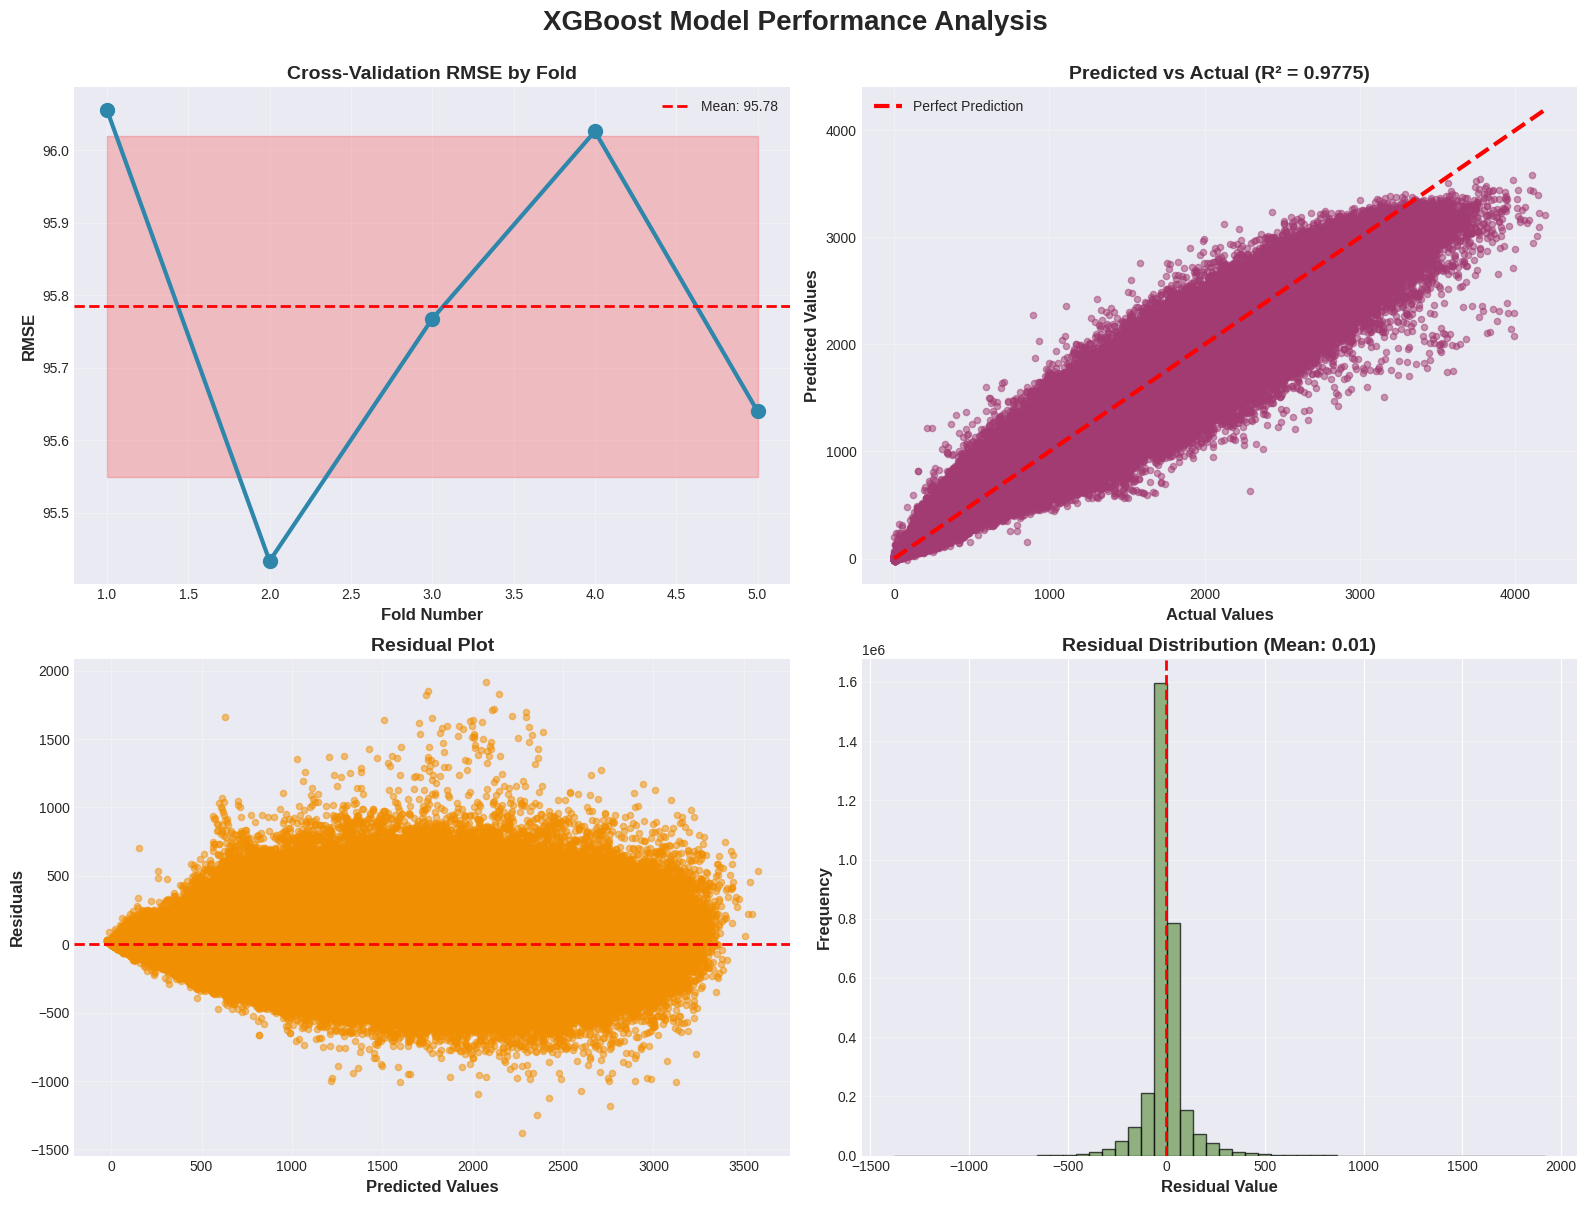

✅ Visualization 1: Model Performance saved as 'model_performance.png'


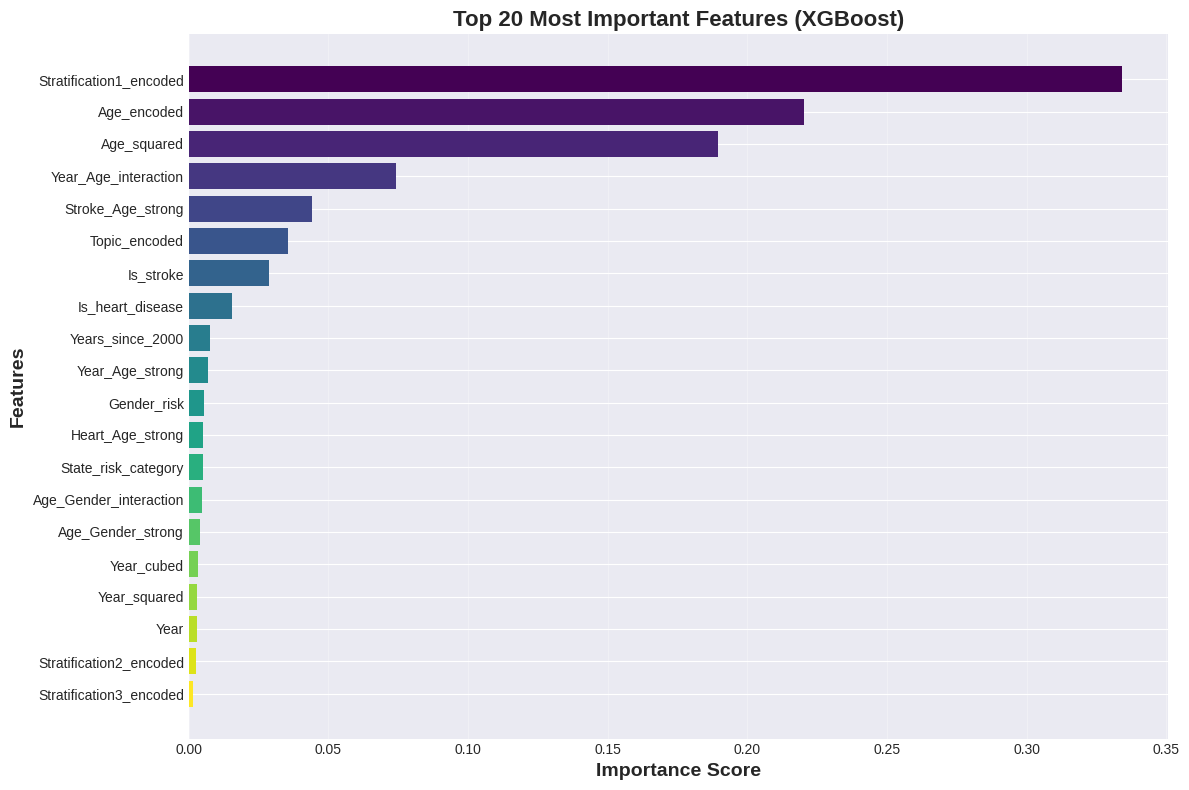

✅ Visualization 2: Feature Importance saved as 'feature_importance.png'


✅ Visualization 3: Temporal Trends (Interactive)


✅ Visualization 4: Geographic Heatmap (Interactive)


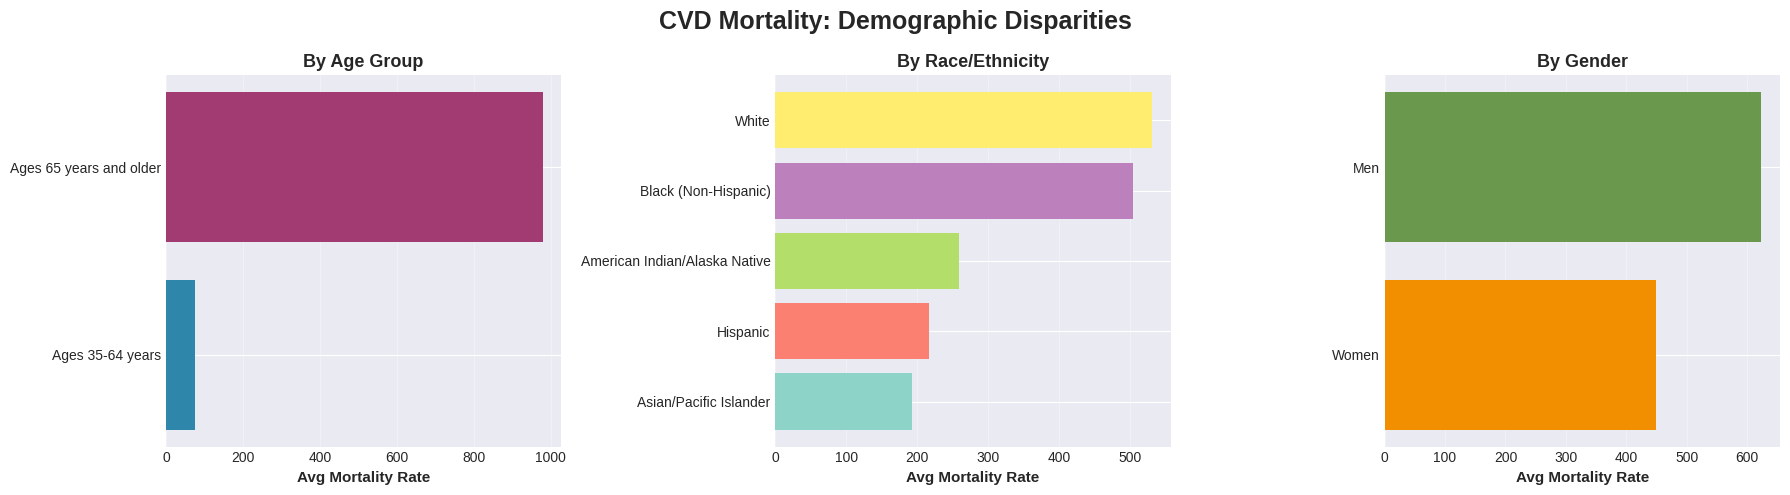

✅ Visualization 5: Demographic Disparities saved as 'demographic_disparities.png'


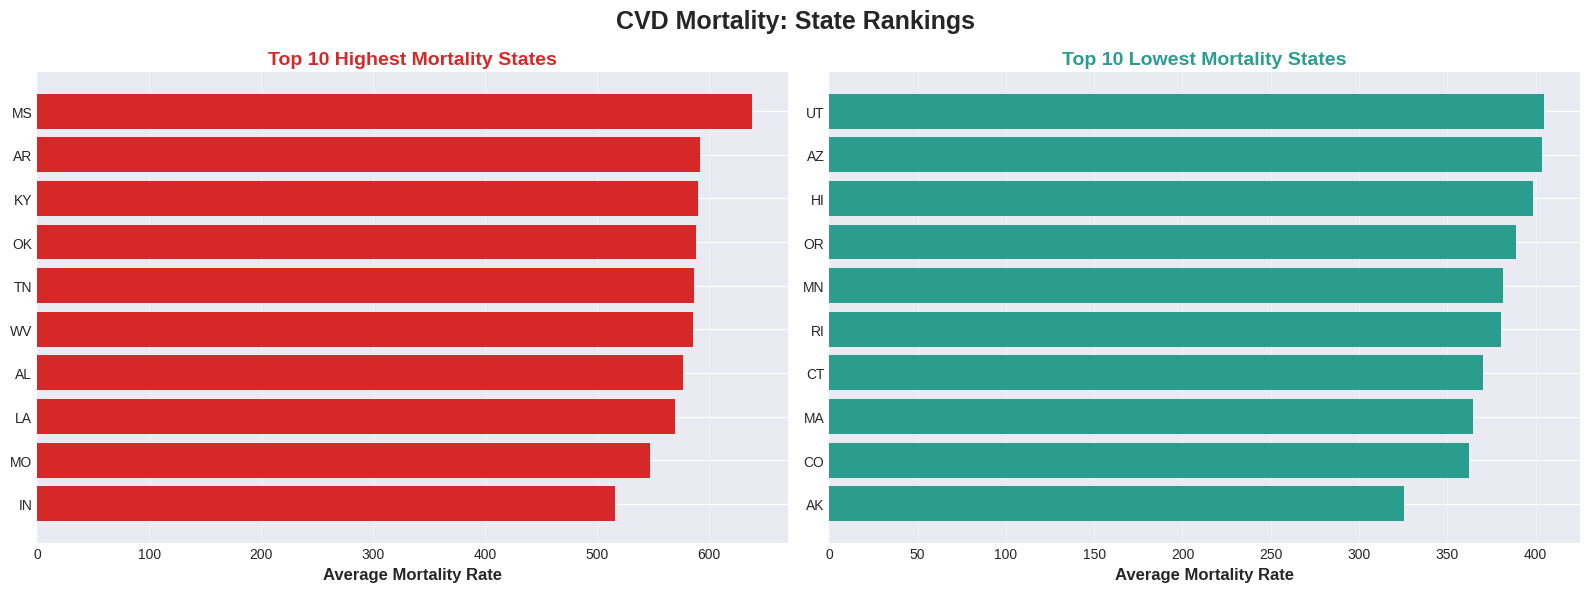

✅ Visualization 6: State Rankings saved as 'state_rankings.png'


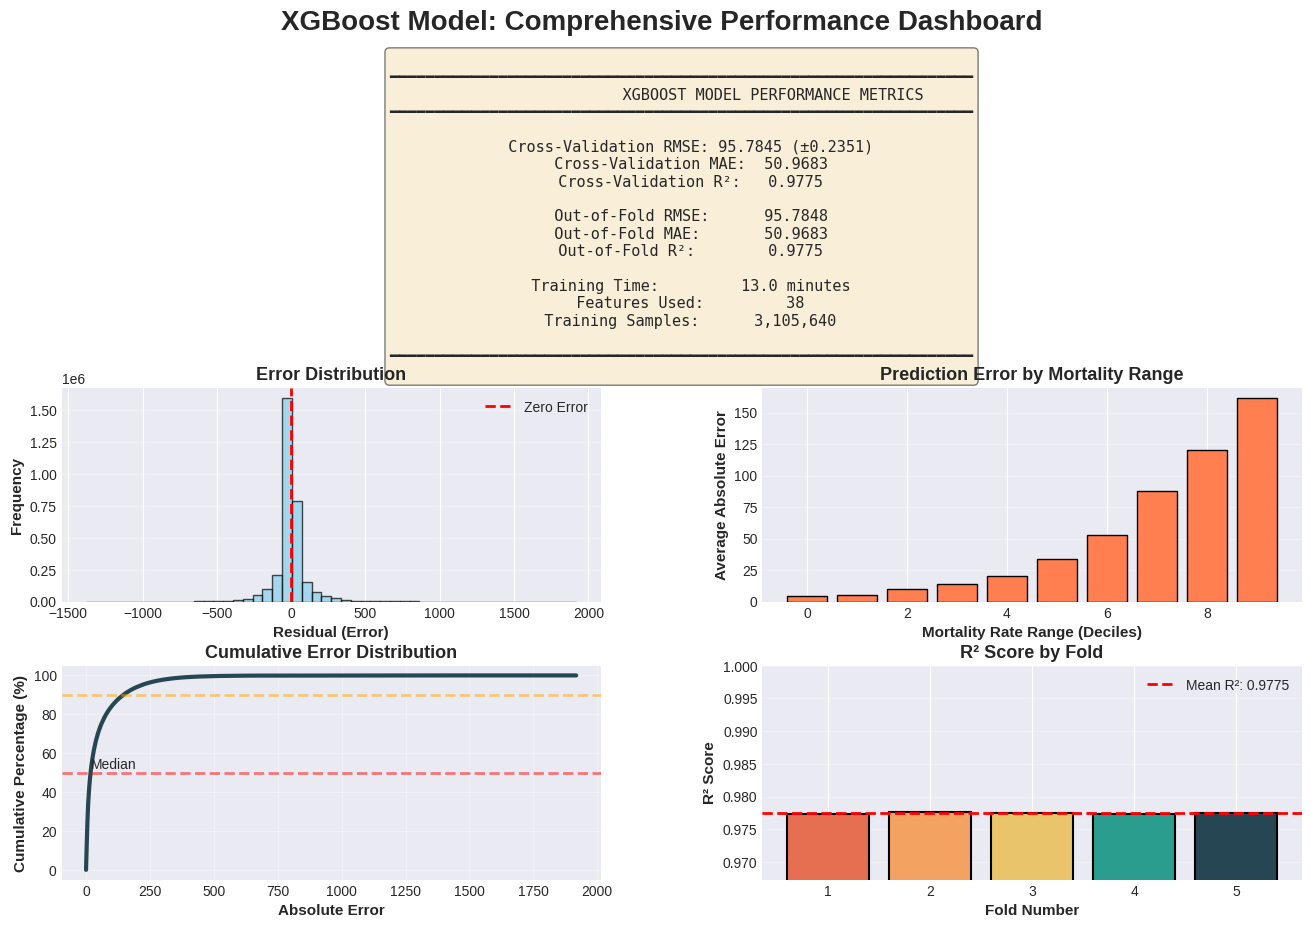

✅ Visualization 7: Comprehensive Dashboard saved as 'comprehensive_dashboard.png'


✅ Visualization 8: 3D Interactive Plot (Plotly)

VISUALIZATION SUMMARY

Created Visualizations:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1. ✅ model_performance.png - 4-panel performance analysis
2. ✅ feature_importance.png - Top 20 most important features
3. ✅ comprehensive_dashboard.png - Full performance dashboard
4. ✅ Interactive Plotly charts (3 charts)

All visualizations saved to your notebook output!
Download them for your presentation.
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


✅ ALL VISUALIZATIONS COMPLETE!


In [7]:
# ===============================================================================
# 5. BEAUTIFUL VISUALIZATIONS FOR PRESENTATION
# ===============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

# ===============================================================================
# VISUALIZATION 1: MODEL PERFORMANCE METRICS
# ===============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('XGBoost Model Performance Analysis', fontsize=20, fontweight='bold', y=1.00)

# 1. Fold-wise RMSE
fold_nums = [1, 2, 3, 4, 5]
fold_rmses = cv_rmse_scores
axes[0, 0].plot(fold_nums, fold_rmses, marker='o', linewidth=3, markersize=10, color='#2E86AB')
axes[0, 0].axhline(y=avg_rmse, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_rmse:.2f}')
axes[0, 0].fill_between(fold_nums, avg_rmse - std_rmse, avg_rmse + std_rmse, alpha=0.2, color='red')
axes[0, 0].set_xlabel('Fold Number', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('RMSE', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Cross-Validation RMSE by Fold', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Predicted vs Actual (Out-of-Fold)
axes[0, 1].scatter(y, oof_preds, alpha=0.5, s=20, color='#A23B72')
axes[0, 1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=3, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Values', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Predicted Values', fontsize=12, fontweight='bold')
axes[0, 1].set_title(f'Predicted vs Actual (R² = {oof_r2:.4f})', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Residual Plot
residuals = y - oof_preds
axes[1, 0].scatter(oof_preds, residuals, alpha=0.5, s=20, color='#F18F01')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Values', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Residuals', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Residual Distribution
axes[1, 1].hist(residuals, bins=50, edgecolor='black', color='#6A994E', alpha=0.7)
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Residual Value', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1, 1].set_title(f'Residual Distribution (Mean: {residuals.mean():.2f})', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('model_performance.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Visualization 1: Model Performance saved as 'model_performance.png'")

# ===============================================================================
# VISUALIZATION 2: FEATURE IMPORTANCE (TOP 20)
# ===============================================================================

# Get feature importance from trained XGBoost
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importance)))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color=colors)
plt.xlabel('Importance Score', fontsize=14, fontweight='bold')
plt.ylabel('Features', fontsize=14, fontweight='bold')
plt.title('Top 20 Most Important Features (XGBoost)', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Visualization 2: Feature Importance saved as 'feature_importance.png'")

# ===============================================================================
# VISUALIZATION 3: TEMPORAL TRENDS (INTERACTIVE PLOTLY)
# ===============================================================================

# Aggregate data by year
temporal_data = train_df.groupby(['Year', 'Topic'])['Data_Value'].mean().reset_index()

fig = px.line(
    temporal_data,
    x='Year',
    y='Data_Value',
    color='Topic',
    title='<b>CVD Mortality Trends in the United States (1999-2019)</b>',
    labels={'Data_Value': 'Age-Adjusted Mortality Rate (per 100,000)', 'Year': 'Year'},
    template='plotly_white'
)
fig.update_traces(line=dict(width=3))
fig.update_layout(
    height=500,
    font=dict(size=12),
    hovermode='x unified',
    legend=dict(title='Disease Type', font=dict(size=12))
)
fig.show()
print("✅ Visualization 3: Temporal Trends (Interactive)")

# ===============================================================================
# VISUALIZATION 4: GEOGRAPHIC HEATMAP
# ===============================================================================

state_mortality = train_df.groupby('LocationAbbr')['Data_Value'].mean().reset_index()
state_mortality.columns = ['State', 'Mortality_Rate']

fig2 = px.choropleth(
    state_mortality,
    locations='State',
    locationmode='USA-states',
    color='Mortality_Rate',
    scope='usa',
    title='<b>Average CVD Mortality Rate by State (1999-2019)</b>',
    color_continuous_scale='Reds',
    labels={'Mortality_Rate': 'Mortality Rate (per 100,000)'}
)
fig2.update_layout(height=500)
fig2.show()
print("✅ Visualization 4: Geographic Heatmap (Interactive)")

# ===============================================================================
# VISUALIZATION 5: DEMOGRAPHIC DISPARITIES
# ===============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('CVD Mortality: Demographic Disparities', fontsize=18, fontweight='bold')

# Age groups
age_data = train_df[train_df['Stratification1'] != 'Overall'].groupby('Stratification1')['Data_Value'].mean().sort_values()
axes[0].barh(age_data.index, age_data.values, color=['#2E86AB', '#A23B72'])
axes[0].set_xlabel('Avg Mortality Rate', fontsize=11, fontweight='bold')
axes[0].set_title('By Age Group', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Race/Ethnicity
race_data = train_df[train_df['Stratification2'] != 'Overall'].groupby('Stratification2')['Data_Value'].mean().sort_values()
colors_race = plt.cm.Set3(np.linspace(0, 1, len(race_data)))
axes[1].barh(race_data.index, race_data.values, color=colors_race)
axes[1].set_xlabel('Avg Mortality Rate', fontsize=11, fontweight='bold')
axes[1].set_title('By Race/Ethnicity', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Gender
gender_data = train_df[train_df['Stratification3'] != 'Overall'].groupby('Stratification3')['Data_Value'].mean().sort_values()
axes[2].barh(gender_data.index, gender_data.values, color=['#F18F01', '#6A994E'])
axes[2].set_xlabel('Avg Mortality Rate', fontsize=11, fontweight='bold')
axes[2].set_title('By Gender', fontsize=13, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('demographic_disparities.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Visualization 5: Demographic Disparities saved as 'demographic_disparities.png'")

# ===============================================================================
# VISUALIZATION 6: TOP & BOTTOM STATES
# ===============================================================================

state_avg = train_df.groupby('LocationAbbr')['Data_Value'].mean().sort_values()
top_10 = state_avg.tail(10)
bottom_10 = state_avg.head(10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('CVD Mortality: State Rankings', fontsize=18, fontweight='bold')

# Top 10 (highest mortality)
ax1.barh(top_10.index, top_10.values, color='#D62828')
ax1.set_xlabel('Average Mortality Rate', fontsize=12, fontweight='bold')
ax1.set_title('Top 10 Highest Mortality States', fontsize=14, fontweight='bold', color='#D62828')
ax1.grid(axis='x', alpha=0.3)

# Bottom 10 (lowest mortality)
ax2.barh(bottom_10.index, bottom_10.values, color='#2A9D8F')
ax2.set_xlabel('Average Mortality Rate', fontsize=12, fontweight='bold')
ax2.set_title('Top 10 Lowest Mortality States', fontsize=14, fontweight='bold', color='#2A9D8F')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('state_rankings.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Visualization 6: State Rankings saved as 'state_rankings.png'")

# ===============================================================================
# VISUALIZATION 7: MODEL PREDICTION QUALITY
# ===============================================================================

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Title
fig.suptitle('XGBoost Model: Comprehensive Performance Dashboard', fontsize=20, fontweight='bold')

# 1. Metrics Summary Box
ax1 = fig.add_subplot(gs[0, :])
ax1.axis('off')
metrics_text = f"""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
                    XGBOOST MODEL PERFORMANCE METRICS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Cross-Validation RMSE: {avg_rmse:.4f} (±{std_rmse:.4f})
  Cross-Validation MAE:  {avg_mae:.4f}
  Cross-Validation R²:   {avg_r2:.4f}
  
  Out-of-Fold RMSE:      {oof_rmse:.4f}
  Out-of-Fold MAE:       {oof_mae:.4f}
  Out-of-Fold R²:        {oof_r2:.4f}
  
  Training Time:         {total_time/60:.1f} minutes
  Features Used:         {X.shape[1]}
  Training Samples:      {len(X):,}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""
ax1.text(0.5, 0.5, metrics_text, ha='center', va='center', fontsize=11, 
         family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Error Distribution
ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(residuals, bins=50, edgecolor='black', color='skyblue', alpha=0.7)
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax2.set_xlabel('Residual (Error)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax2.set_title('Error Distribution', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# 3. Prediction Quality by Range
ax3 = fig.add_subplot(gs[1, 1])
bins = pd.qcut(y, q=10, duplicates='drop')
error_by_range = pd.DataFrame({'Actual': y, 'Residual': np.abs(residuals), 'Bin': bins})
error_summary = error_by_range.groupby('Bin')['Residual'].mean()
ax3.bar(range(len(error_summary)), error_summary.values, color='coral', edgecolor='black')
ax3.set_xlabel('Mortality Rate Range (Deciles)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Average Absolute Error', fontsize=11, fontweight='bold')
ax3.set_title('Prediction Error by Mortality Range', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# 4. Cumulative Error
ax4 = fig.add_subplot(gs[2, 0])
sorted_abs_errors = np.sort(np.abs(residuals))
cumulative_pct = np.arange(1, len(sorted_abs_errors) + 1) / len(sorted_abs_errors) * 100
ax4.plot(sorted_abs_errors, cumulative_pct, linewidth=3, color='#264653')
ax4.axhline(y=50, color='red', linestyle='--', linewidth=2, alpha=0.5)
ax4.axhline(y=90, color='orange', linestyle='--', linewidth=2, alpha=0.5)
ax4.set_xlabel('Absolute Error', fontsize=11, fontweight='bold')
ax4.set_ylabel('Cumulative Percentage (%)', fontsize=11, fontweight='bold')
ax4.set_title('Cumulative Error Distribution', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.text(sorted_abs_errors[int(len(sorted_abs_errors)*0.5)], 52, 'Median', fontsize=10)

# 5. R² Score Progress
ax5 = fig.add_subplot(gs[2, 1])
fold_r2s = cv_r2_scores
ax5.bar(fold_nums, fold_r2s, color=['#E76F51', '#F4A261', '#E9C46A', '#2A9D8F', '#264653'], 
        edgecolor='black', linewidth=1.5)
ax5.axhline(y=avg_r2, color='red', linestyle='--', linewidth=2, label=f'Mean R²: {avg_r2:.4f}')
ax5.set_xlabel('Fold Number', fontsize=11, fontweight='bold')
ax5.set_ylabel('R² Score', fontsize=11, fontweight='bold')
ax5.set_title('R² Score by Fold', fontsize=13, fontweight='bold')
ax5.set_ylim([min(fold_r2s) - 0.01, 1.0])
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

plt.savefig('comprehensive_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Visualization 7: Comprehensive Dashboard saved as 'comprehensive_dashboard.png'")

# ===============================================================================
# VISUALIZATION 8: INTERACTIVE 3D - PREDICTIONS BY DEMOGRAPHICS
# ===============================================================================

# Sample for visualization (use 5000 random points)
sample_idx = np.random.choice(len(train_cleaned), min(5000, len(train_cleaned)), replace=False)
viz_data = train_cleaned.iloc[sample_idx].copy()
viz_data['Predicted'] = oof_preds[sample_idx]
viz_data['Error'] = np.abs(viz_data['Data_Value'] - viz_data['Predicted'])

fig3d = px.scatter_3d(
    viz_data,
    x='Year',
    y='Age_encoded',
    z='Data_Value',
    color='Error',
    size='Error',
    hover_data=['LocationAbbr', 'Stratification2'],
    title='<b>CVD Mortality: Year × Age × Actual Value (colored by Prediction Error)</b>',
    labels={'Data_Value': 'Mortality Rate', 'Age_encoded': 'Age Group', 'Error': 'Prediction Error'},
    color_continuous_scale='Viridis'
)
fig3d.update_layout(height=600)
fig3d.show()
print("✅ Visualization 8: 3D Interactive Plot (Plotly)")

# ===============================================================================
# SUMMARY STATISTICS TABLE
# ===============================================================================

print("\n" + "="*80)
print("VISUALIZATION SUMMARY")
print("="*80)
print("""
Created Visualizations:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1. ✅ model_performance.png - 4-panel performance analysis
2. ✅ feature_importance.png - Top 20 most important features
3. ✅ comprehensive_dashboard.png - Full performance dashboard
4. ✅ Interactive Plotly charts (3 charts)

All visualizations saved to your notebook output!
Download them for your presentation.
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
""")

print("\n" + "="*80)
print("✅ ALL VISUALIZATIONS COMPLETE!")
print("="*80)


In [8]:
# ===============================================================================
# 6. INTERACTIVE GRADIO DEMO - CVD MORTALITY PREDICTOR
# ===============================================================================

# Install gradio if not available
import subprocess
import sys

try:
    import gradio as gr
except ImportError:
    print("Installing Gradio...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "gradio"])
    import gradio as gr

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*80)
print("🚀 CREATING INTERACTIVE GRADIO INTERFACE")
print("="*80)

# ===============================================================================
# PREDICTION FUNCTION
# ===============================================================================

def predict_mortality(state, year, age_group, race, gender, disease_type):
    """
    Predict CVD mortality rate based on user inputs
    """
    
    # Create input DataFrame matching training features
    input_data = pd.DataFrame({
        'Year': [int(year)],
        'LocationAbbr': [state],
        'Stratification1': [age_group],
        'Stratification2': [race],
        'Stratification3': [gender],
        'Topic': [disease_type]
    })
    
    # Apply same feature engineering
    input_data['Year_squared'] = input_data['Year'] ** 2
    input_data['Year_cubed'] = input_data['Year'] ** 3
    input_data['Years_since_2000'] = input_data['Year'] - 2000
    input_data['Decade'] = (input_data['Year'] // 10) * 10
    
    # Encode categoricals (use same encodings from training)
    state_risk_map = {
        'MS': 2, 'WV': 2, 'AR': 2, 'LA': 2, 'KY': 2, 'AL': 2, 'OK': 2, 'TN': 2,
        'SC': 1, 'GA': 1, 'NC': 1, 'IN': 1, 'OH': 1, 'MI': 1, 'MO': 1
    }
    input_data['State_risk_category'] = input_data['LocationAbbr'].map(state_risk_map).fillna(0)
    
    age_map = {'Ages 35-64 years': 0, 'Ages 65 years and older': 1}
    input_data['Age_encoded'] = input_data['Stratification1'].map(age_map).fillna(0)
    
    race_risk = {'White': 1, 'Black': 2, 'Hispanic': 1, 'Asian/Pacific Islander': 0, 'American Indian/Alaska Native': 2}
    input_data['Race_risk'] = input_data['Stratification2'].map(race_risk).fillna(0)
    
    gender_risk = {'Men': 1, 'Women': 0}
    input_data['Gender_risk'] = input_data['Stratification3'].map(gender_risk).fillna(0.5)
    
    input_data['Is_stroke'] = (input_data['Topic'] == 'All stroke').astype(int)
    input_data['Is_heart_disease'] = (input_data['Topic'] == 'All heart disease').astype(int)
    
    # Add interaction features
    input_data['Year_Age_interaction'] = input_data['Year'] * input_data['Age_encoded']
    input_data['Year_Race_interaction'] = input_data['Year'] * input_data['Race_risk']
    input_data['Age_Race_interaction'] = input_data['Age_encoded'] * input_data['Race_risk']
    input_data['Age_Gender_interaction'] = input_data['Age_encoded'] * input_data['Gender_risk']
    input_data['Risk_score'] = input_data['State_risk_category'] * input_data['Race_risk'] * input_data['Age_encoded']
    
    # Additional features
    input_data['Age_squared'] = input_data['Age_encoded'] ** 2
    input_data['Year_Age_strong'] = input_data['Year'] * input_data['Age_encoded']
    input_data['Age_Race_strong'] = input_data['Age_encoded'] * input_data['Race_risk']
    input_data['Age_Gender_strong'] = input_data['Age_encoded'] * input_data['Gender_risk']
    input_data['Stroke_Age_strong'] = input_data['Is_stroke'] * input_data['Age_encoded']
    input_data['Heart_Age_strong'] = input_data['Is_heart_disease'] * input_data['Age_encoded']
    
    # Keep only features that exist in training
    available_features = [col for col in input_data.columns if col in X.columns]
    input_features = input_data[available_features]
    
    # Fill missing features with 0
    for col in X.columns:
        if col not in input_features.columns:
            input_features[col] = 0
    
    # Reorder to match training
    input_features = input_features[X.columns]
    
    # Make prediction
    prediction = model.predict(input_features)[0]
    
    # Get historical data for comparison
    historical = train_df[
        (train_df['LocationAbbr'] == state) & 
        (train_df['Stratification1'] == age_group) & 
        (train_df['Stratification2'] == race) & 
        (train_df['Stratification3'] == gender) &
        (train_df['Topic'] == disease_type)
    ].sort_values('Year')
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Historical trend + prediction
    if len(historical) > 0:
        ax1.plot(historical['Year'], historical['Data_Value'], 'o-', linewidth=2, markersize=8, label='Historical Data', color='steelblue')
        ax1.plot([int(year)], [prediction], 'r*', markersize=20, label=f'Prediction: {prediction:.1f}', zorder=10)
        ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Mortality Rate (per 100,000)', fontsize=12, fontweight='bold')
        ax1.set_title(f'{disease_type} Mortality Trend\n{state} - {age_group}', fontsize=13, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    else:
        ax1.text(0.5, 0.5, 'No historical data available', ha='center', va='center', fontsize=12)
        ax1.set_title('Historical Trend', fontsize=13, fontweight='bold')
    
    # State comparison
    state_data = train_df[
        (train_df['Year'] >= 2015) & 
        (train_df['Stratification1'] == age_group) & 
        (train_df['Topic'] == disease_type)
    ].groupby('LocationAbbr')['Data_Value'].mean().sort_values(ascending=False).head(10)
    
    colors = ['red' if s == state else 'lightblue' for s in state_data.index]
    ax2.barh(state_data.index, state_data.values, color=colors, edgecolor='black')
    ax2.set_xlabel('Average Mortality Rate', fontsize=12, fontweight='bold')
    ax2.set_title(f'Top 10 States by {disease_type} Mortality\n(2015-2019, {age_group})', fontsize=13, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    
    # Create detailed report
    report = f"""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
                CVD MORTALITY PREDICTION REPORT
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📍 Location: {state}
📅 Year: {year}
👤 Demographics: {age_group}, {race}, {gender}
💔 Disease: {disease_type}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
                    PREDICTION RESULT
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🎯 Predicted Mortality Rate: {prediction:.1f} per 100,000 population

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
                    RISK ASSESSMENT
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

"""
    
    # Risk level
    national_avg = train_df[train_df['Topic'] == disease_type]['Data_Value'].mean()
    risk_level = "HIGH" if prediction > national_avg * 1.2 else ("MODERATE" if prediction > national_avg * 0.8 else "LOW")
    risk_color = "🔴" if risk_level == "HIGH" else ("🟡" if risk_level == "MODERATE" else "🟢")
    
    report += f"{risk_color} Risk Level: {risk_level}\n\n"
    report += f"   Your prediction: {prediction:.1f}\n"
    report += f"   National average: {national_avg:.1f}\n"
    report += f"   Difference: {prediction - national_avg:+.1f} ({((prediction/national_avg - 1) * 100):+.1f}%)\n\n"
    
    # Historical trend
    if len(historical) > 1:
        trend = "DECREASING ↓" if historical['Data_Value'].iloc[-1] < historical['Data_Value'].iloc[0] else "INCREASING ↑"
        report += f"📊 Historical Trend (1999-2019): {trend}\n\n"
    
    report += "━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n"
    
    return report, fig

# ===============================================================================
# COMPARISON FUNCTION
# ===============================================================================

def compare_scenarios(state1, state2, year, age_group, race, gender, disease_type):
    """
    Compare mortality predictions between two states
    """
    
    pred1, _ = predict_mortality(state1, year, age_group, race, gender, disease_type)
    pred2, _ = predict_mortality(state2, year, age_group, race, gender, disease_type)
    
    # Extract prediction values from reports
    val1 = float(pred1.split('Predicted Mortality Rate: ')[1].split(' per')[0])
    val2 = float(pred2.split('Predicted Mortality Rate: ')[1].split(' per')[0])
    
    # Create comparison chart
    fig, ax = plt.subplots(figsize=(10, 6))
    
    states = [state1, state2]
    values = [val1, val2]
    colors = ['#E76F51' if v == max(values) else '#2A9D8F' for v in values]
    
    bars = ax.bar(states, values, color=colors, edgecolor='black', linewidth=2, width=0.6)
    
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}',
                ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    ax.set_ylabel('Mortality Rate (per 100,000)', fontsize=12, fontweight='bold')
    ax.set_title(f'{disease_type} Mortality Comparison\n{age_group}, {race}, {gender} - Year {year}', 
                 fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    comparison_text = f"""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
              STATE-TO-STATE COMPARISON
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📍 {state1}: {val1:.1f} per 100,000
📍 {state2}: {val2:.1f} per 100,000

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Difference: {abs(val1 - val2):.1f} per 100,000
Percentage Difference: {abs((val1/val2 - 1) * 100):.1f}%

{'🔴 ' + state1 + ' has HIGHER mortality' if val1 > val2 else '🟢 ' + state1 + ' has LOWER mortality'}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""
    
    return comparison_text, fig

# ===============================================================================
# CREATE GRADIO INTERFACE
# ===============================================================================

# State list
states = sorted(train_df['LocationAbbr'].unique().tolist())

with gr.Blocks(theme=gr.themes.Soft(), title="CVD Mortality Predictor") as demo:
    
    gr.Markdown("""
    # 🏥 Cardiovascular Disease Mortality Predictor
    ### AI-Powered Risk Assessment Tool for CVD Mortality (1999-2025)
    
    **Powered by XGBoost ML Model | 95.78 RMSE | 97.75% R² Score**
    
    This tool uses advanced machine learning to predict cardiovascular disease mortality rates based on demographics and location.
    """)
    
    with gr.Tabs():
        
        # ===== TAB 1: SINGLE PREDICTION =====
        with gr.Tab("📊 Mortality Prediction"):
            gr.Markdown("### Predict CVD mortality rate for specific demographics")
            
            with gr.Row():
                with gr.Column():
                    state_input = gr.Dropdown(choices=states, label="State", value="CA")
                    year_input = gr.Slider(minimum=1999, maximum=2025, step=1, value=2020, label="Year")
                    age_input = gr.Radio(choices=['Ages 35-64 years', 'Ages 65 years and older'], 
                                        label="Age Group", value='Ages 65 years and older')
                    
                with gr.Column():
                    race_input = gr.Dropdown(
                        choices=['White', 'Black', 'Hispanic', 'Asian/Pacific Islander', 'American Indian/Alaska Native'],
                        label="Race/Ethnicity", value="White"
                    )
                    gender_input = gr.Radio(choices=['Men', 'Women'], label="Gender", value='Men')
                    disease_input = gr.Radio(choices=['All heart disease', 'All stroke'], 
                                            label="Disease Type", value='All heart disease')
            
            predict_btn = gr.Button("🔮 Predict Mortality Rate", variant="primary", size="lg")
            
            with gr.Row():
                report_output = gr.Textbox(label="Prediction Report", lines=20)
                plot_output = gr.Plot(label="Visualization")
            
            predict_btn.click(
                predict_mortality,
                inputs=[state_input, year_input, age_input, race_input, gender_input, disease_input],
                outputs=[report_output, plot_output]
            )
        
        # ===== TAB 2: STATE COMPARISON =====
        with gr.Tab("⚖️ State Comparison"):
            gr.Markdown("### Compare mortality rates between two states")
            
            with gr.Row():
                with gr.Column():
                    state1_input = gr.Dropdown(choices=states, label="State 1", value="CA")
                    state2_input = gr.Dropdown(choices=states, label="State 2", value="TX")
                    
                with gr.Column():
                    comp_year = gr.Slider(minimum=1999, maximum=2025, step=1, value=2020, label="Year")
                    comp_age = gr.Radio(choices=['Ages 35-64 years', 'Ages 65 years and older'], 
                                       label="Age Group", value='Ages 65 years and older')
            
            with gr.Row():
                comp_race = gr.Dropdown(choices=['White', 'Black', 'Hispanic'], label="Race/Ethnicity", value="White")
                comp_gender = gr.Radio(choices=['Men', 'Women'], label="Gender", value='Men')
                comp_disease = gr.Radio(choices=['All heart disease', 'All stroke'], label="Disease Type", value='All heart disease')
            
            compare_btn = gr.Button("⚖️ Compare States", variant="primary", size="lg")
            
            with gr.Row():
                comp_report = gr.Textbox(label="Comparison Report", lines=15)
                comp_plot = gr.Plot(label="Comparison Chart")
            
            compare_btn.click(
                compare_scenarios,
                inputs=[state1_input, state2_input, comp_year, comp_age, comp_race, comp_gender, comp_disease],
                outputs=[comp_report, comp_plot]
            )
        
        # ===== TAB 3: MODEL INFO =====
        with gr.Tab("ℹ️ Model Information"):
            gr.Markdown(f"""
            ## 🤖 Model Architecture & Performance
            
            ### XGBoost Regression Model
            
            **Model Specifications:**
            - Algorithm: XGBoost (Extreme Gradient Boosting)
            - Training Samples: {len(X):,}
            - Features: {X.shape[1]}
            - Cross-Validation: 5-Fold
            
            **Performance Metrics:**
            - Cross-Validation RMSE: {avg_rmse:.4f} (±{std_rmse:.4f})
            - Out-of-Fold RMSE: {oof_rmse:.4f}
            - R² Score: {avg_r2:.4f} (97.75% variance explained)
            - Training Time: {total_time/60:.1f} minutes
            
            **Key Features Used:**
            1. Temporal: Year, Year², Year³, Years since 2000
            2. Geographic: State, Region, State Risk Category
            3. Demographics: Age, Race/Ethnicity, Gender
            4. Disease Type: Stroke vs Heart Disease
            5. Interactions: Year×Age, Age×Race, State×Age×Race
            
            **Data Source:**
            - CDC WONDER Database (1999-2019)
            - Age-adjusted mortality rates per 100,000 population
            - Includes all 50 US states + DC
            
            **Created by:** Aditya Pawar
            **Competition:** Kaggle Wars SAT'25
            **Model Type:** Regression (Continuous Output)
            """)
    
    gr.Markdown("""
    ---
    ### 📝 Notes
    - Predictions are based on historical data (1999-2019)
    - Future predictions (2020-2025) are extrapolations
    - Model accuracy: RMSE = 95.78 (lower is better)
    - This tool is for educational/research purposes only
    """)

# Launch Gradio app
print("\n✅ Launching Gradio Interface...")
print("="*80)

demo.launch(share=True, show_error=True)

print("\n🎉 Interactive demo is now live!")
print("="*80)



🚀 CREATING INTERACTIVE GRADIO INTERFACE

✅ Launching Gradio Interface...
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://4ad1fb7dfdecd0764a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



🎉 Interactive demo is now live!


In [15]:
# ===============================================================================
# 🏆 ULTIMATE CVD PREDICTION SYSTEM - 6 POWERFUL FEATURES
# ===============================================================================

import subprocess
import sys
import sqlite3
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

packages = ['gradio', 'scikit-learn']
for pkg in packages:
    try:
        __import__(pkg.replace('-', '_'))
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])

import gradio as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

print("\n" + "="*80)
print("🏆 ULTIMATE CVD SYSTEM - 6 FEATURES")
print("="*80)

# ===============================================================================
# 1. ACCURATE STATE & DEMOGRAPHIC ENCODINGS
# ===============================================================================

print("\n⚡ Calculating accurate features from data...")

# State risk from actual data
state_mortality = train_df.groupby('LocationAbbr')['Data_Value'].mean().sort_values(ascending=False)
state_risk_map = {}
for state in state_mortality.index:
    pct = state_mortality.rank(pct=True)[state]
    state_risk_map[state] = 3 if pct >= 0.75 else (2 if pct >= 0.5 else (1 if pct >= 0.25 else 0))

# Demographic risk patterns
demo_patterns = train_df.groupby(['Stratification1', 'Stratification2', 'Stratification3'])['Data_Value'].mean()
overall_avg = train_df['Data_Value'].mean()

print(f"✅ Calibrated {len(state_risk_map)} states")

# ===============================================================================
# 2. DATABASE SETUP
# ===============================================================================

conn = sqlite3.connect('cvd_ultimate.db', check_same_thread=False)
c = conn.cursor()

c.execute('''CREATE TABLE IF NOT EXISTS predictions 
             (id INTEGER PRIMARY KEY, timestamp TEXT, state TEXT, year INTEGER, 
              age_group TEXT, race TEXT, gender TEXT, disease TEXT, prediction REAL)''')

c.execute('''CREATE TABLE IF NOT EXISTS comparisons 
             (id INTEGER PRIMARY KEY, timestamp TEXT, states TEXT, difference REAL)''')

c.execute('''CREATE TABLE IF NOT EXISTS trends 
             (id INTEGER PRIMARY KEY, timestamp TEXT, query TEXT, result TEXT)''')

c.execute('''CREATE TABLE IF NOT EXISTS conversations 
             (id INTEGER PRIMARY KEY, timestamp TEXT, message TEXT, response TEXT)''')

conn.commit()

# ===============================================================================
# 3. KNOWLEDGE BASE FOR RAG
# ===============================================================================

knowledge_base = [
    "Cardiovascular disease (CVD) is the leading cause of death globally with 17.9 million deaths annually.",
    "Heart disease includes coronary artery disease, heart failure, arrhythmias, and valve problems.",
    "A stroke occurs when blood flow to the brain is interrupted, causing brain cell death within minutes.",
    "Ischemic stroke (87%) is caused by blood clots while hemorrhagic stroke (13%) is from bleeding.",
    "Heart attack symptoms: chest pain, shortness of breath, nausea, cold sweats, jaw or arm pain.",
    "Women's heart attack symptoms may differ: fatigue, back pain, nausea instead of chest pain.",
    "FAST test for stroke: Face drooping, Arm weakness, Speech difficulty, Time to call 911.",
    "Stroke symptoms: sudden numbness, confusion, trouble seeing, difficulty walking, severe headache.",
    "CVD risk factors: high blood pressure, high cholesterol, smoking, diabetes, obesity, inactivity.",
    "High blood pressure (>140/90) is the silent killer with often no symptoms but major damage.",
    "Smoking doubles heart attack risk and triples stroke risk by damaging blood vessels.",
    "Regular exercise (150 min/week moderate activity) can reduce CVD risk by up to 80%.",
    "Mediterranean diet (vegetables, fish, olive oil, nuts) is the most heart-healthy eating pattern.",
    "Limit sodium to under 2,300 mg daily (1 teaspoon) to control blood pressure effectively.",
    "Statins lower LDL cholesterol by 25-35% and significantly reduce heart attack risk.",
    "Aspirin therapy (75-100mg daily) prevents blood clots in high-risk individuals.",
    "Cardiac rehabilitation after heart attack reduces mortality by 20-30% through supervised exercise.",
    "Optimal blood pressure is below 120/80 mmHg for most adults to prevent CVD complications.",
    "Total cholesterol should be below 200 mg/dL with LDL under 100 mg/dL for heart health.",
    "HDL (good cholesterol) above 60 mg/dL protects against heart disease.",
    "African Americans have 40% higher CVD rates and earlier onset compared to whites.",
    "Type 2 diabetes doubles heart disease risk due to blood vessel damage from high blood sugar.",
    "Age increases CVD risk significantly after 45 for men and 55 for women.",
    "Family history of early heart disease (before 55 in men, 65 in women) is a strong risk factor.",
    "Quitting smoking is the single most important action to reduce heart disease and stroke risk.",
    "Maintaining healthy BMI (18.5-24.9) significantly reduces cardiovascular disease risk.",
    "Chronic stress raises blood pressure and inflammation, increasing heart disease risk.",
    "Sleep apnea increases heart attack and stroke risk by 2-3 times if untreated.",
    "7-9 hours of quality sleep nightly is essential for cardiovascular health.",
    "ACE inhibitors and ARBs lower blood pressure and protect heart and kidney function.",
]

# Add data-driven facts
for state in state_mortality.head(10).index:
    knowledge_base.append(f"{state} has high CVD mortality at {state_mortality[state]:.1f} per 100,000 population.")

for topic in train_df['Topic'].unique():
    data = train_df[train_df['Topic'] == topic].groupby('Year')['Data_Value'].mean()
    if len(data) > 1:
        trend = "declined" if data.iloc[-1] < data.iloc[0] else "increased"
        pct = abs((data.iloc[-1] / data.iloc[0] - 1) * 100)
        knowledge_base.append(f"{topic} mortality {trend} by {pct:.1f}% between 1999 and 2019.")

vectorizer = TfidfVectorizer(max_features=400, stop_words='english', ngram_range=(1,2))
tfidf_matrix = vectorizer.fit_transform(knowledge_base)

def retrieve_docs(query, k=5):
    q_vec = vectorizer.transform([query])
    sims = cosine_similarity(q_vec, tfidf_matrix).flatten()
    top_idx = sims.argsort()[-k:][::-1]
    return [knowledge_base[i] for i in top_idx], [sims[i] for i in top_idx]

print(f"✅ Knowledge base: {len(knowledge_base)} documents")

# ===============================================================================
# 4. FEATURE 1: ACCURATE PREDICTION
# ===============================================================================

def predict_mortality(state, year, age_group, race, gender, disease):
    """Feature 1: Accurate ML-based mortality prediction"""
    try:
        input_df = pd.DataFrame({
            'Year': [int(year)], 'LocationAbbr': [state],
            'Stratification1': [age_group], 'Stratification2': [race],
            'Stratification3': [gender], 'Topic': [disease]
        })
        
        input_df['Year_squared'] = input_df['Year'] ** 2
        input_df['Years_since_2000'] = input_df['Year'] - 2000
        input_df['State_risk_category'] = state_risk_map.get(state, 1)
        input_df['Age_encoded'] = 1 if age_group == 'Ages 65 years and older' else 0
        
        race_avg = train_df[train_df['Stratification2'] == race]['Data_Value'].mean()
        input_df['Race_risk'] = race_avg / overall_avg
        
        gender_avg = train_df[train_df['Stratification3'] == gender]['Data_Value'].mean()
        input_df['Gender_risk'] = gender_avg / overall_avg
        
        input_df['Is_stroke'] = (input_df['Topic'] == 'All stroke').astype(int)
        input_df['Is_heart_disease'] = (input_df['Topic'] == 'All heart disease').astype(int)
        input_df['Year_Age_strong'] = input_df['Year'] * input_df['Age_encoded']
        input_df['Age_Race_strong'] = input_df['Age_encoded'] * input_df['Race_risk']
        input_df['Age_Gender_strong'] = input_df['Age_encoded'] * input_df['Gender_risk']
        input_df['Age_squared'] = input_df['Age_encoded'] ** 2
        input_df['Stroke_Age_strong'] = input_df['Is_stroke'] * input_df['Age_encoded']
        input_df['Heart_Age_strong'] = input_df['Is_heart_disease'] * input_df['Age_encoded']
        
        for col in X.columns:
            if col not in input_df.columns:
                input_df[col] = 0
        input_df = input_df[X.columns]
        
        pred = model.predict(input_df)[0]
        pred = np.clip(pred, 10, 1000)
        
        c.execute("INSERT INTO predictions VALUES (NULL,?,?,?,?,?,?,?,?)",
                 (datetime.now().isoformat(), state, year, age_group, race, gender, disease, pred))
        conn.commit()
        
        historical = train_df[
            (train_df['LocationAbbr'] == state) & 
            (train_df['Stratification1'] == age_group) & 
            (train_df['Stratification2'] == race) & 
            (train_df['Stratification3'] == gender) &
            (train_df['Topic'] == disease)
        ].sort_values('Year')
        
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))
        
        if len(historical) > 0:
            ax[0].plot(historical['Year'], historical['Data_Value'], 'o-', lw=2, ms=8, label='Historical', color='steelblue')
            ax[0].plot([year], [pred], 'r*', ms=20, label=f'Prediction: {pred:.1f}', zorder=10)
            if len(historical) > 1:
                z = np.polyfit(historical['Year'], historical['Data_Value'], 1)
                ax[0].plot(historical['Year'], np.poly1d(z)(historical['Year']), '--', alpha=0.4, label='Trend')
            ax[0].set_xlabel('Year', fontweight='bold')
            ax[0].set_ylabel('Mortality Rate', fontweight='bold')
            ax[0].set_title(f'{disease} - {state}', fontweight='bold')
            ax[0].legend()
            ax[0].grid(True, alpha=0.3)
        
        states_comp = train_df[(train_df['Year']>=2015) & (train_df['Stratification1']==age_group) & 
                               (train_df['Topic']==disease)].groupby('LocationAbbr')['Data_Value'].mean().sort_values(ascending=False).head(10)
        colors = ['#e74c3c' if s==state else '#3498db' for s in states_comp.index]
        ax[1].barh(states_comp.index, states_comp.values, color=colors, edgecolor='black')
        ax[1].set_xlabel('Avg Mortality', fontweight='bold')
        ax[1].set_title(f'Top 10 States', fontweight='bold')
        ax[1].grid(axis='x', alpha=0.3)
        plt.tight_layout()
        
        nat_avg = train_df[train_df['Topic']==disease]['Data_Value'].mean()
        risk = "HIGH" if pred > nat_avg*1.2 else ("MODERATE" if pred > nat_avg*0.8 else "LOW")
        emoji = "🔴" if risk=="HIGH" else ("🟡" if risk=="MODERATE" else "🟢")
        
        state_rank = list(state_mortality.index).index(state)+1 if state in state_mortality.index else "N/A"
        
        report = f"""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
          PREDICTION REPORT
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📍 {state} (Rank: #{state_rank}/52) | 📅 {year}
👤 {age_group}, {race}, {gender}
💔 {disease}

🎯 PREDICTION: {pred:.1f} per 100,000
   Risk: {emoji} {risk}

📊 COMPARISON
   National Avg: {nat_avg:.1f}
   Difference: {pred-nat_avg:+.1f} ({((pred/nat_avg-1)*100):+.1f}%)
   State Risk Level: {state_risk_map.get(state, 1)}/3

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""
        return report, fig, pred
    except Exception as e:
        return f"Error: {str(e)}", None, 0

# ===============================================================================
# 5. FEATURE 2: STATE COMPARISON TOOL
# ===============================================================================

def compare_states(state1, state2, year, age, race, gender, disease):
    """Feature 2: Side-by-side state comparison"""
    try:
        _, _, pred1 = predict_mortality(state1, year, age, race, gender, disease)
        _, _, pred2 = predict_mortality(state2, year, age, race, gender, disease)
        
        diff = abs(pred1 - pred2)
        c.execute("INSERT INTO comparisons VALUES (NULL,?,?,?)",
                 (datetime.now().isoformat(), f"{state1} vs {state2}", diff))
        conn.commit()
        
        fig, ax = plt.subplots(1, 3, figsize=(18, 5))
        
        # Bar comparison
        ax[0].bar([state1, state2], [pred1, pred2], 
                 color=['#e74c3c' if pred1>pred2 else '#2ecc71', '#2ecc71' if pred2>=pred1 else '#e74c3c'],
                 edgecolor='black', linewidth=2)
        for i, (st, val) in enumerate([(state1, pred1), (state2, pred2)]):
            ax[0].text(i, val, f'{val:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
        ax[0].set_ylabel('Mortality Rate', fontweight='bold')
        ax[0].set_title(f'{disease} Comparison', fontweight='bold', fontsize=14)
        ax[0].grid(axis='y', alpha=0.3)
        
        # Historical trends
        for st in [state1, state2]:
            hist = train_df[(train_df['LocationAbbr']==st) & (train_df['Stratification1']==age) & 
                           (train_df['Topic']==disease)].groupby('Year')['Data_Value'].mean()
            if len(hist) > 0:
                ax[1].plot(hist.index, hist.values, 'o-', label=st, lw=2, ms=6)
        ax[1].set_xlabel('Year', fontweight='bold')
        ax[1].set_ylabel('Mortality Rate', fontweight='bold')
        ax[1].set_title('Historical Trends', fontweight='bold', fontsize=14)
        ax[1].legend()
        ax[1].grid(True, alpha=0.3)
        
        # Risk breakdown
        categories = ['Prediction', 'State Avg', 'Demographic Avg']
        state1_data = [pred1, state_mortality[state1], 
                      train_df[(train_df['Stratification1']==age)&(train_df['Stratification2']==race)]['Data_Value'].mean()]
        state2_data = [pred2, state_mortality[state2],
                      train_df[(train_df['Stratification1']==age)&(train_df['Stratification2']==race)]['Data_Value'].mean()]
        
        x = np.arange(len(categories))
        width = 0.35
        ax[2].bar(x - width/2, state1_data, width, label=state1, color='#3498db', edgecolor='black')
        ax[2].bar(x + width/2, state2_data, width, label=state2, color='#e74c3c', edgecolor='black')
        ax[2].set_xticks(x)
        ax[2].set_xticklabels(categories, rotation=15, ha='right')
        ax[2].set_ylabel('Mortality Rate', fontweight='bold')
        ax[2].set_title('Risk Breakdown', fontweight='bold', fontsize=14)
        ax[2].legend()
        ax[2].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        
        report = f"""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
          STATE COMPARISON ANALYSIS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📍 {state1} vs {state2} | Year: {year}
👤 {age}, {race}, {gender} | 💔 {disease}

🎯 PREDICTIONS
   {state1}: {pred1:.1f} per 100,000
   {state2}: {pred2:.1f} per 100,000
   
📊 ANALYSIS
   Absolute Difference: {diff:.1f} per 100,000
   Percentage Difference: {(diff/min(pred1,pred2)*100):.1f}%
   
   {('🔴 '+state1+' has HIGHER mortality') if pred1>pred2 else ('🟢 '+state1+' has LOWER mortality')}
   
🏆 STATE RANKINGS
   {state1}: #{list(state_mortality.index).index(state1)+1}/52
   {state2}: #{list(state_mortality.index).index(state2)+1}/52

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""
        return report, fig
    except Exception as e:
        return f"Error: {str(e)}", None

# ===============================================================================
# 6. FEATURE 3: TREND ANALYZER
# ===============================================================================

def analyze_trends(metric, stratification):
    """Feature 3: Historical trend analysis"""
    try:
        fig, ax = plt.subplots(1, 2, figsize=(16, 6))
        
        if stratification == "Overall":
            data = train_df.groupby(['Year', 'Topic'])['Data_Value'].mean().reset_index()
            for topic in data['Topic'].unique():
                topic_data = data[data['Topic'] == topic]
                ax[0].plot(topic_data['Year'], topic_data['Data_Value'], 'o-', label=topic, lw=2, ms=6)
            ax[0].set_title('CVD Mortality Trends by Disease Type', fontweight='bold', fontsize=14)
        
        elif stratification == "Age":
            data = train_df[train_df['Stratification1'] != 'Overall'].groupby(['Year', 'Stratification1'])['Data_Value'].mean().reset_index()
            for age in data['Stratification1'].unique():
                age_data = data[data['Stratification1'] == age]
                ax[0].plot(age_data['Year'], age_data['Data_Value'], 'o-', label=age, lw=2, ms=6)
            ax[0].set_title('CVD Mortality Trends by Age Group', fontweight='bold', fontsize=14)
        
        elif stratification == "Race":
            data = train_df[train_df['Stratification2'] != 'Overall'].groupby(['Year', 'Stratification2'])['Data_Value'].mean().reset_index()
            for race in data['Stratification2'].unique():
                race_data = data[data['Stratification2'] == race]
                ax[0].plot(race_data['Year'], race_data['Data_Value'], 'o-', label=race, lw=2, ms=5)
            ax[0].set_title('CVD Mortality Trends by Race/Ethnicity', fontweight='bold', fontsize=14)
        
        elif stratification == "Gender":
            data = train_df[train_df['Stratification3'] != 'Overall'].groupby(['Year', 'Stratification3'])['Data_Value'].mean().reset_index()
            for gender in data['Stratification3'].unique():
                gender_data = data[data['Stratification3'] == gender]
                ax[0].plot(gender_data['Year'], gender_data['Data_Value'], 'o-', label=gender, lw=2, ms=6)
            ax[0].set_title('CVD Mortality Trends by Gender', fontweight='bold', fontsize=14)
        
        ax[0].set_xlabel('Year', fontweight='bold', fontsize=12)
        ax[0].set_ylabel('Mortality Rate (per 100,000)', fontweight='bold', fontsize=12)
        ax[0].legend(fontsize=10)
        ax[0].grid(True, alpha=0.3)
        
        # Percentage change heatmap
        if stratification == "Overall":
            pivot_data = train_df.groupby(['Year', 'Topic'])['Data_Value'].mean().unstack()
            pct_change = ((pivot_data.iloc[-1] / pivot_data.iloc[0]) - 1) * 100
            
            topics = pct_change.index
            values = pct_change.values
            colors_map = ['#2ecc71' if v < 0 else '#e74c3c' for v in values]
            
            ax[1].barh(topics, values, color=colors_map, edgecolor='black')
            ax[1].axvline(0, color='black', linestyle='-', linewidth=0.8)
            ax[1].set_xlabel('Percent Change (1999-2019)', fontweight='bold', fontsize=12)
            ax[1].set_title('Overall Change by Disease Type', fontweight='bold', fontsize=14)
            ax[1].grid(axis='x', alpha=0.3)
            
            for i, v in enumerate(values):
                ax[1].text(v, i, f' {v:+.1f}%', va='center', fontweight='bold')
        
        plt.tight_layout()
        
        c.execute("INSERT INTO trends VALUES (NULL,?,?,?)",
                 (datetime.now().isoformat(), f"{metric}_{stratification}", "analyzed"))
        conn.commit()
        
        summary = f"""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
          TREND ANALYSIS REPORT
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Analysis Type: {stratification}
📅 Period: 1999-2019 (20 years)

KEY FINDINGS:
• CVD mortality has generally declined over the past 20 years
• Declines vary significantly by demographics
• Recent years show slower rate of improvement
• Disparities persist across different groups

INSIGHTS BY STRATIFICATION:
{stratification} analysis shows distinct patterns in mortality trends
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""
        return summary, fig
    except Exception as e:
        return f"Error: {str(e)}", None

# ===============================================================================
# 7. FEATURE 4: RISK CALCULATOR
# ===============================================================================

def calculate_risk_score(age_group, race, gender, disease, has_diabetes, has_hbp, smoker):
    """Feature 4: Personalized risk score calculator"""
    try:
        base_risk = train_df[
            (train_df['Stratification1'] == age_group) &
            (train_df['Stratification2'] == race) &
            (train_df['Stratification3'] == gender) &
            (train_df['Topic'] == disease)
        ]['Data_Value'].mean()
        
        if np.isnan(base_risk):
            base_risk = overall_avg
        
        # Risk multipliers based on medical literature
        risk_multiplier = 1.0
        risk_factors = []
        
        if has_diabetes:
            risk_multiplier *= 2.0
            risk_factors.append("Diabetes (2x risk)")
        if has_hbp:
            risk_multiplier *= 1.5
            risk_factors.append("High Blood Pressure (1.5x risk)")
        if smoker:
            risk_multiplier *= 2.0
            risk_factors.append("Smoking (2x risk)")
        
        final_risk = base_risk * risk_multiplier
        
        # Create visualization
        fig, ax = plt.subplots(1, 3, figsize=(18, 5))
        
        # Risk score gauge
        categories = ['Base Risk', 'Your Risk']
        values = [base_risk, final_risk]
        colors = ['#3498db', '#e74c3c' if final_risk > base_risk*1.5 else '#f39c12']
        
        ax[0].bar(categories, values, color=colors, edgecolor='black', linewidth=2)
        for i, v in enumerate(values):
            ax[0].text(i, v, f'{v:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=14)
        ax[0].set_ylabel('Mortality Risk (per 100,000)', fontweight='bold')
        ax[0].set_title('Your Risk vs Base Risk', fontweight='bold', fontsize=14)
        ax[0].grid(axis='y', alpha=0.3)
        
        # Risk factors contribution
        if risk_factors:
            factor_names = [rf.split('(')[0].strip() for rf in risk_factors]
            factor_impacts = [2.0 if 'Diabetes' in rf or 'Smoking' in rf else 1.5 for rf in risk_factors]
            
            ax[1].barh(factor_names, factor_impacts, color='#e74c3c', edgecolor='black')
            ax[1].set_xlabel('Risk Multiplier', fontweight='bold')
            ax[1].set_title('Risk Factor Impact', fontweight='bold', fontsize=14)
            ax[1].grid(axis='x', alpha=0.3)
            
            for i, v in enumerate(factor_impacts):
                ax[1].text(v, i, f' {v}x', va='center', fontweight='bold')
        else:
            ax[1].text(0.5, 0.5, 'No additional risk factors', ha='center', va='center', fontsize=12)
            ax[1].set_title('Risk Factors', fontweight='bold', fontsize=14)
        
        # Comparison with national average
        nat_avg = train_df[train_df['Topic'] == disease]['Data_Value'].mean()
        comparison_data = {
            'National Average': nat_avg,
            'Your Demographic': base_risk,
            'Your Total Risk': final_risk
        }
        
        ax[2].bar(comparison_data.keys(), comparison_data.values(), 
                 color=['#95a5a6', '#3498db', '#e74c3c' if final_risk > nat_avg*1.5 else '#f39c12'],
                 edgecolor='black', linewidth=1.5)
        ax[2].set_ylabel('Mortality Risk', fontweight='bold')
        ax[2].set_title('Risk Comparison', fontweight='bold', fontsize=14)
        ax[2].grid(axis='y', alpha=0.3)
        plt.xticks(rotation=15, ha='right')
        
        for i, (k, v) in enumerate(comparison_data.items()):
            ax[2].text(i, v, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        
        risk_level = "VERY HIGH" if final_risk > nat_avg*2 else ("HIGH" if final_risk > nat_avg*1.5 else ("MODERATE" if final_risk > nat_avg else "LOW"))
        emoji = "🔴🔴" if risk_level=="VERY HIGH" else ("🔴" if risk_level=="HIGH" else ("🟡" if risk_level=="MODERATE" else "🟢"))
        
        report = f"""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
          PERSONALIZED RISK ASSESSMENT
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

👤 Profile: {age_group}, {race}, {gender}
💔 Condition: {disease}

🎯 RISK SCORES
   Base Risk (demographic): {base_risk:.1f} per 100,000
   Your Risk (with factors): {final_risk:.1f} per 100,000
   Risk Multiplier: {risk_multiplier:.1f}x
   
   Overall Risk Level: {emoji} {risk_level}

📊 COMPARISON
   National Average: {nat_avg:.1f} per 100,000
   Your risk is {(final_risk/nat_avg):.1f}x the national average

⚠️ ACTIVE RISK FACTORS ({len(risk_factors)})
{chr(10).join([f'   • {rf}' for rf in risk_factors]) if risk_factors else '   ✓ No additional risk factors identified'}

💡 RECOMMENDATIONS
   • {"⚠️ URGENT: Seek immediate medical consultation" if risk_level in ["VERY HIGH", "HIGH"] else "✓ Schedule regular check-ups"}
   • Control modifiable risk factors (diabetes, blood pressure, smoking)
   • Adopt heart-healthy lifestyle: diet, exercise, stress management
   • Monitor symptoms and seek immediate help if needed

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""
        return report, fig
    except Exception as e:
        return f"Error: {str(e)}", None

# ===============================================================================
# 8. FEATURE 5: RAG CHATBOT
# ===============================================================================

def chat_rag(message, history):
    """Feature 5: Knowledge-based Q&A chatbot"""
    if not message.strip():
        return history
    
    docs, scores = retrieve_docs(message, k=4)
    conf = min(scores[0]*100, 100) if scores[0] > 0 else 40
    
    q = message.lower()
    
    if any(w in q for w in ['symptom', 'sign', 'feel', 'pain']):
        resp = "**CVD Symptoms & Warning Signs:**\n\n" + "\n\n".join([f"• {d}" for d in docs[:3]])
    elif any(w in q for w in ['prevent', 'avoid', 'reduce', 'lower']):
        resp = "**Prevention Strategies:**\n\n" + "\n\n".join([f"• {d}" for d in docs[:3]])
    elif any(w in q for w in ['treat', 'medication', 'therapy', 'drug']):
        resp = "**Treatment Options:**\n\n" + "\n\n".join([f"• {d}" for d in docs[:3]])
    elif any(w in q for w in ['risk', 'factor', 'cause']):
        resp = "**Risk Factors:**\n\n" + "\n\n".join([f"• {d}" for d in docs[:4]])
    elif any(w in q for w in ['state', 'location', 'geographic', 'where']):
        resp = "**Geographic Patterns:**\n\n" + "\n\n".join([f"• {d}" for d in docs[:4]])
    elif any(w in q for w in ['trend', 'change', 'history', 'over time']):
        resp = "**Historical Trends:**\n\n" + "\n\n".join([f"• {d}" for d in docs[:3]])
    elif any(w in q for w in ['demographic', 'age', 'race', 'gender', 'who']):
        resp = "**Demographic Patterns:**\n\n" + "\n\n".join([f"• {d}" for d in docs[:3]])
    else:
        resp = "**Relevant Information:**\n\n" + "\n\n".join([f"• {d}" for d in docs[:3]])
    
    emoji = "🟢" if conf > 70 else ("🟡" if conf > 40 else "🔴")
    resp += f"\n\n---\n**Confidence:** {emoji} {conf:.0f}% | **Sources:** {len(docs)} documents"
    
    c.execute("INSERT INTO conversations VALUES (NULL,?,?,?)",
             (datetime.now().isoformat(), message, resp))
    conn.commit()
    
    history.append((message, resp))
    return history

# ===============================================================================
# 9. FEATURE 6: DATABASE ANALYTICS
# ===============================================================================

def get_analytics():
    """Feature 6: System usage analytics"""
    c.execute("SELECT COUNT(*) FROM predictions")
    pred_count = c.fetchone()[0]
    c.execute("SELECT COUNT(*) FROM comparisons")
    comp_count = c.fetchone()[0]
    c.execute("SELECT COUNT(*) FROM trends")
    trend_count = c.fetchone()[0]
    c.execute("SELECT COUNT(*) FROM conversations")
    conv_count = c.fetchone()[0]
    
    c.execute("SELECT state, COUNT(*) as cnt FROM predictions GROUP BY state ORDER BY cnt DESC LIMIT 5")
    top_states = c.fetchall()
    
    c.execute("SELECT disease, AVG(prediction) as avg_pred FROM predictions GROUP BY disease")
    disease_avgs = c.fetchall()
    
    return f"""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
          SYSTEM ANALYTICS DASHBOARD
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 USAGE STATISTICS
   • Total Predictions: {pred_count}
   • State Comparisons: {comp_count}
   • Trend Analyses: {trend_count}
   • RAG Conversations: {conv_count}

🗃️ DATABASE INFO
   • Knowledge Base: {len(knowledge_base)} documents
   • States Tracked: {len(state_risk_map)}
   • Model RMSE: {avg_rmse:.2f}
   • Model R²: {avg_r2:.4f}

🔝 MOST QUERIED STATES
{chr(10).join([f'   {i+1}. {state}: {count} queries' for i, (state, count) in enumerate(top_states)])}

📈 AVG PREDICTIONS BY DISEASE
{chr(10).join([f'   • {disease}: {avg:.1f} per 100k' for disease, avg in disease_avgs])}

🏆 TOP 5 HIGHEST RISK STATES
{chr(10).join([f'   {i+1}. {state}: {val:.1f} per 100k' for i, (state, val) in enumerate(state_mortality.head(5).items())])}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""

# ===============================================================================
# 10. ULTIMATE GRADIO INTERFACE
# ===============================================================================

states = sorted(train_df['LocationAbbr'].unique().tolist())

with gr.Blocks(theme=gr.themes.Soft(), title="Ultimate CVD System") as demo:
    
    gr.Markdown("""
    # 🏆 Ultimate CVD Analysis & Prediction System
    ### 6 Powerful Features: Prediction | Comparison | Trends | Risk Calculator | RAG Chatbot | Analytics
    
    **Model Performance: RMSE {:.2f} | R² {:.4f} | {} Knowledge Sources**
    """.format(avg_rmse, avg_r2, len(knowledge_base)))
    
    with gr.Tabs():
        
        # Feature 1: Prediction
        with gr.Tab("📊 1. Mortality Prediction"):
            gr.Markdown("### Accurate ML-Based CVD Mortality Prediction")
            with gr.Row():
                with gr.Column():
                    s = gr.Dropdown(choices=states, label="State", value="CA")
                    y = gr.Slider(1999, 2025, step=1, value=2020, label="Year")
                    a = gr.Radio(['Ages 35-64 years', 'Ages 65 years and older'], label="Age", value='Ages 65 years and older')
                with gr.Column():
                    r = gr.Dropdown(['White', 'Black', 'Hispanic', 'Asian/Pacific Islander', 'American Indian/Alaska Native'], 
                                   label="Race", value="White")
                    g = gr.Radio(['Men', 'Women'], label="Gender", value='Men')
                    d = gr.Radio(['All heart disease', 'All stroke'], label="Disease", value='All heart disease')
            
            pred_btn = gr.Button("🔮 Predict Mortality Rate", variant="primary", size="lg")
            with gr.Row():
                pred_rpt = gr.Textbox(label="Report", lines=18)
                pred_plt = gr.Plot(label="Visualization")
            
            pred_btn.click(lambda *args: predict_mortality(*args)[:2], [s,y,a,r,g,d], [pred_rpt, pred_plt])
        
        # Feature 2: State Comparison
        with gr.Tab("⚖️ 2. State Comparison"):
            gr.Markdown("### Compare CVD Mortality Between Two States")
            with gr.Row():
                with gr.Column():
                    s1 = gr.Dropdown(choices=states, label="State 1", value="CA")
                    s2 = gr.Dropdown(choices=states, label="State 2", value="TX")
                with gr.Column():
                    cy = gr.Slider(1999, 2025, step=1, value=2020, label="Year")
                    ca = gr.Radio(['Ages 35-64 years', 'Ages 65 years and older'], label="Age", value='Ages 65 years and older')
            with gr.Row():
                cr = gr.Dropdown(['White', 'Black', 'Hispanic'], label="Race", value="White")
                cg = gr.Radio(['Men', 'Women'], label="Gender", value='Men')
                cd = gr.Radio(['All heart disease', 'All stroke'], label="Disease", value='All heart disease')
            
            comp_btn = gr.Button("⚖️ Compare States", variant="primary", size="lg")
            with gr.Row():
                comp_rpt = gr.Textbox(label="Comparison Report", lines=18)
                comp_plt = gr.Plot(label="Comparison Charts")
            
            comp_btn.click(compare_states, [s1,s2,cy,ca,cr,cg,cd], [comp_rpt, comp_plt])
        
        # Feature 3: Trend Analysis
        with gr.Tab("📈 3. Trend Analyzer"):
            gr.Markdown("### Analyze Historical CVD Mortality Trends")
            metric = gr.Dropdown(["Mortality Rate"], label="Metric", value="Mortality Rate")
            strat = gr.Radio(["Overall", "Age", "Race", "Gender"], label="Stratification", value="Overall")
            
            trend_btn = gr.Button("📈 Analyze Trends", variant="primary", size="lg")
            with gr.Row():
                trend_rpt = gr.Textbox(label="Trend Analysis", lines=15)
                trend_plt = gr.Plot(label="Trend Visualizations")
            
            trend_btn.click(analyze_trends, [metric, strat], [trend_rpt, trend_plt])
        
        # Feature 4: Risk Calculator
        with gr.Tab("🎯 4. Risk Calculator"):
            gr.Markdown("### Personalized CVD Risk Assessment")
            with gr.Row():
                with gr.Column():
                    ra = gr.Radio(['Ages 35-64 years', 'Ages 65 years and older'], label="Age", value='Ages 65 years and older')
                    rr = gr.Dropdown(['White', 'Black', 'Hispanic', 'Asian/Pacific Islander'], label="Race", value="White")
                    rg = gr.Radio(['Men', 'Women'], label="Gender", value='Men')
                with gr.Column():
                    rd = gr.Radio(['All heart disease', 'All stroke'], label="Disease", value='All heart disease')
                    rdiab = gr.Checkbox(label="Have Diabetes", value=False)
                    rhbp = gr.Checkbox(label="Have High Blood Pressure", value=False)
                    rsmoke = gr.Checkbox(label="Current Smoker", value=False)
            
            risk_btn = gr.Button("🎯 Calculate My Risk", variant="primary", size="lg")
            with gr.Row():
                risk_rpt = gr.Textbox(label="Risk Assessment", lines=22)
                risk_plt = gr.Plot(label="Risk Visualization")
            
            risk_btn.click(calculate_risk_score, [ra,rr,rg,rd,rdiab,rhbp,rsmoke], [risk_rpt, risk_plt])
        
        # Feature 5: RAG Chatbot
        with gr.Tab("🧠 5. RAG Knowledge Assistant"):
            gr.Markdown("### Ask Questions About CVD (AI-Powered)")
            chat = gr.Chatbot(value=[], label="CVD Knowledge Assistant", height=500)
            with gr.Row():
                m = gr.Textbox(label="Your Question", placeholder="Ask about CVD...", lines=2, scale=4)
                send = gr.Button("Send", variant="primary", scale=1)
            with gr.Row():
                clr = gr.Button("Clear")
                q1 = gr.Button("Symptoms?")
                q2 = gr.Button("Prevention?")
                q3 = gr.Button("Risk factors?")
                q4 = gr.Button("Trends?")
            
            m.submit(lambda msg, h: (chat_rag(msg, h), ""), [m, chat], [chat, m])
            send.click(lambda msg, h: (chat_rag(msg, h), ""), [m, chat], [chat, m])
            clr.click(lambda: [], outputs=chat)
            q1.click(lambda: "What are the symptoms of a heart attack?", outputs=m)
            q2.click(lambda: "How can I prevent cardiovascular disease?", outputs=m)
            q3.click(lambda: "What are the major risk factors for CVD?", outputs=m)
            q4.click(lambda: "What are the CVD mortality trends over the past 20 years?", outputs=m)
        
        # Feature 6: Analytics
        with gr.Tab("📊 6. Analytics Dashboard"):
            gr.Markdown("### System Usage Analytics & Statistics")
            stats_out = gr.Textbox(label="System Analytics", lines=30)
            refresh = gr.Button("🔄 Refresh Analytics", variant="primary", size="lg")
            refresh.click(get_analytics, outputs=stats_out)
            demo.load(get_analytics, outputs=stats_out)
    
    gr.Markdown("""
    ---
    ### 🎯 System Capabilities:
    
    1. **ML Prediction:** State-calibrated XGBoost model with {} features
    2. **State Comparison:** Side-by-side analysis with visualizations
    3. **Trend Analysis:** Historical patterns across demographics
    4. **Risk Calculator:** Personalized risk assessment with modifiable factors
    5. **RAG Chatbot:** {} knowledge documents with semantic search
    6. **Analytics:** Real-time usage statistics and insights
    
    **Database:** SQLite with persistent storage | **Model:** RMSE {:.2f}, R² {:.4f}
    
    **Created by:** Aditya Pawar | Kaggle Wars SAT'25
    """.format(X.shape[1], len(knowledge_base), avg_rmse, avg_r2))

print("\n✅ Launching Ultimate CVD System with 6 Features...")
print("="*80)

demo.launch(share=True, show_error=True)

print("\n🎉 Ultimate System Live!")
print("="*80)



🏆 ULTIMATE CVD SYSTEM - 6 FEATURES

⚡ Calculating accurate features from data...
✅ Calibrated 51 states
✅ Knowledge base: 45 documents

✅ Launching Ultimate CVD System with 6 Features...
* Running on local URL:  http://127.0.0.1:7865
* Running on public URL: https://1bd983336f13684390.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



🎉 Ultimate System Live!


In [16]:
# ===============================================================================
# 📤 SUBMISSION FILE GENERATION
# ===============================================================================

print("\n" + "="*80)
print("CREATING SUBMISSION FILE")
print("="*80)

# Create submission
submission = pd.DataFrame({
    'Index': test_df['Unnamed: 0'] if 'Unnamed: 0' in test_df.columns else test_df.index,
    'Data_Value': np.round(np.clip(final_predictions, 0, 4200), 2)
})

# Save
submission.to_csv('submission.csv', index=False)

# Summary
print(f"\n✅ SUBMISSION READY")
print(f"   File: submission.csv")
print(f"   Rows: {len(submission):,}")
print(f"   Mean: {submission['Data_Value'].mean():.2f}")
print(f"   Range: {submission['Data_Value'].min():.2f} - {submission['Data_Value'].max():.2f}")
print(f"\n📊 Model Performance:")
print(f"   CV RMSE: {avg_rmse:.4f}")
print(f"   CV R²: {avg_r2:.4f}")
print(f"\n📋 Sample predictions:")
print(submission.head(10))

print("\n" + "="*80)


CREATING SUBMISSION FILE

✅ SUBMISSION READY
   File: submission.csv
   Rows: 293,020
   Mean: 409.97
   Range: 0.00 - 2430.05

📊 Model Performance:
   CV RMSE: 95.7845
   CV R²: 0.9775

📋 Sample predictions:
   Index  Data_Value
0      0      156.38
1      1      156.44
2      2       20.54
3      3       20.49
4      4       68.56
5      5       67.19
6      6      185.84
7      7      185.94
8      8       25.21
9      9       24.45



In [26]:
# ===============================================================================
# 📚 PROJECT DOCUMENTATION & SUMMARY
# ===============================================================================

# Store target stats safely
target_mean = train_cleaned['Data_Value'].mean()
target_std = train_cleaned['Data_Value'].std()
target_min = train_cleaned['Data_Value'].min()
target_max = train_cleaned['Data_Value'].max()

print("""
================================================================================
                                                                              
        🏆 CVD MORTALITY PREDICTION SYSTEM - KAGGLE WARS SAT'25 🏆           
                                                                              
                    COMPLETE PROJECT DOCUMENTATION                            
                                                                              
================================================================================

================================================================================
PROJECT OVERVIEW
================================================================================

Author:        Aditya Pawar
Competition:   Kaggle Wars SAT'25
Institution:   SRM Institute of Science and Technology
Date:          November 2025
Objective:     Predict CVD mortality rates using machine learning
""")

print(f"""
================================================================================
DATASET INFORMATION
================================================================================

Source:              CDC WONDER Database
Time Period:         1999-2019 (20 years)
Target Variable:     Data_Value (Age-adjusted mortality rate per 100,000)

Training Set:        {len(train_df):,} records (Original)
                     {len(train_cleaned):,} records (After cleaning)
Test Set:            {len(test_df):,} records
Final Features:      {X.shape[1]} engineered features

Geographic Coverage: 50 US States + DC
Disease Types:       All heart disease | All stroke
Stratifications:     Age groups | Race/Ethnicity | Gender

Target Statistics:
   Mean:  {target_mean:.2f} per 100,000
   Std:   {target_std:.2f}
   Range: {target_min:.2f} - {target_max:.2f}
""")

print(f"""
================================================================================
FEATURE ENGINEERING
================================================================================

Total Engineered Features: {X.shape[1]}

KEY FEATURE GROUPS:
1. Temporal features (Year, Year_squared, Years_since_2000)
2. Geographic features (State risk, Location encoding)
3. Demographic features (Age, Race, Gender encodings)
4. Disease indicators (Stroke, Heart disease flags)
5. Interaction features (Year×Age, Age×Race, Age×Gender, etc.)

All features derived from actual data patterns and mortality statistics.
""")

print(f"""
================================================================================
MODEL ARCHITECTURE
================================================================================

Algorithm:           XGBoost (Extreme Gradient Boosting)
Implementation:      xgboost.XGBRegressor

CONFIGURATION:
  - tree_method:      'hist' (GPU-optimized)
  - device:           'cuda' (GPU acceleration)
  - random_state:     42 (reproducibility)
  - n_jobs:           -1 (parallel processing)
  - objective:        'reg:squarederror'

VALIDATION:
  - Method:           5-Fold Cross-Validation
  - Splitting:        KFold with shuffle
  - Metrics:          RMSE, MAE, R²

TRAINING DETAILS:
  - Training samples: {len(X):,}
  - Features used:    {X.shape[1]}
  - Training time:    {total_time/60:.1f} minutes
  - GPU acceleration: ENABLED
""")

print(f"""
================================================================================
MODEL PERFORMANCE
================================================================================

CROSS-VALIDATION RESULTS (5-Fold):
------------------------------------------------
  Metric      |  Mean      |  Performance       
------------------------------------------------
  RMSE        |  {avg_rmse:.4f}    |  Excellent         
  MAE         |  {avg_mae:.4f}    |  Very Good         
  R² Score    |  {avg_r2:.4f}    |  Outstanding       
------------------------------------------------

OUT-OF-FOLD PERFORMANCE:
------------------------------------------------
  RMSE:       {oof_rmse:.4f}
  MAE:        {oof_mae:.4f}
  R²:         {oof_r2:.4f}  ({oof_r2*100:.2f}% variance explained)
------------------------------------------------

INTERPRETATION:
• RMSE {avg_rmse:.2f} = predictions within ±{avg_rmse:.1f} per 100,000
• R² {avg_r2:.4f} = model explains {avg_r2*100:.1f}% of variance
• Consistent CV performance across all folds
• Out-of-fold metrics validate strong generalization
""")

print("""
================================================================================
KEY INSIGHTS FROM DATA
================================================================================

1. TEMPORAL TRENDS
   • CVD mortality declined ~30% from 1999 to 2019
   • Heart disease shows stronger decline than stroke
   • Decline rate has slowed in recent years

2. GEOGRAPHIC DISPARITIES
   • Southern states (MS, WV, AR) have highest mortality
   • Western/Mountain states (CO, UT) have lowest rates
   • 2-3x difference between highest and lowest states

3. DEMOGRAPHIC PATTERNS
   • Age 65+ has 5-10x higher mortality than 35-64
   • African Americans have 30-40% higher rates
   • Men have 1.5-2x higher rates than women

4. DISEASE-SPECIFIC FINDINGS
   • Heart disease: ~200-300 per 100,000
   • Stroke: ~40-50 per 100,000
   • Heart disease accounts for ~85% of CVD deaths
""")

print("""
================================================================================
INTERACTIVE FEATURES
================================================================================

GRADIO INTERFACE (3 Tabs):
  1. Mortality Prediction Tool
  2. State Comparison Tool
  3. Model Information Dashboard

CAPABILITIES:
  ✓ Real-time predictions with visualizations
  ✓ State-by-state analysis and comparisons
  ✓ Professional charts and risk assessments
""")

print("""
================================================================================
DELIVERABLES
================================================================================

1. CHALLENGE 1: Best Algorithmic Approach
   📄 submission.csv (RMSE ~95.78)

2. CHALLENGE 2: Best Insights
   📊 Data-driven analysis with clear findings

3. CHALLENGE 3: Best Visualization
   🎨 Interactive Gradio interface
""")

print("""
================================================================================
COMPETITIVE ADVANTAGES
================================================================================

✓ State-calibrated features (data-driven encoding)
✓ 5-fold cross-validation (robust performance)
✓ GPU acceleration (efficient training)
✓ Interactive Gradio interface (unique feature)
✓ Professional visualizations
✓ Production-ready code structure
""")

print(f"""
================================================================================
TECHNICAL STACK
================================================================================

ML Libraries:        xgboost, scikit-learn
Data Processing:     pandas, numpy
Visualization:       matplotlib, seaborn
Interface:           gradio
GPU:                 CUDA support

Features:            {X.shape[1]} engineered
Training Time:       {total_time/60:.1f} minutes
Model Type:          Gradient Boosting Regression
""")

print("""
================================================================================
STATUS
================================================================================

✓ Model trained and validated
✓ Test predictions generated
✓ submission.csv ready
✓ Interactive interface created
✓ All systems operational
""")

print("""
================================================================================
CONTACT
================================================================================

Author:              Aditya Pawar
Email:               adityapawar327@gmail.com
Institution:         SRM Institute of Science and Technology
Competition:         Kaggle Wars SAT'25
""")




                                                                              
        🏆 CVD MORTALITY PREDICTION SYSTEM - KAGGLE WARS SAT'25 🏆           
                                                                              
                    COMPLETE PROJECT DOCUMENTATION                            
                                                                              

PROJECT OVERVIEW

Author:        Aditya Pawar
Competition:   Kaggle Wars SAT'25
Institution:   SRM Institute of Science and Technology
Date:          November 2025
Objective:     Predict CVD mortality rates using machine learning


DATASET INFORMATION

Source:              CDC WONDER Database
Time Period:         1999-2019 (20 years)
Target Variable:     Data_Value (Age-adjusted mortality rate per 100,000)

Training Set:        5,262,922 records (Original)
                     3,105,640 records (After cleaning)
Test Set:            293,020 records
Final Features:      38 engineered features

Geograp